In [1]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

import sys
sys.path.append('..')

import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import os

from src.beam import beam_arguments, Experiment, get_beam_parser
from src.beam import UniversalDataset, UniversalBatchSampler
from src.beam import Algorithm, PackedFolds
from src.beam import DataTensor, BeamOptimizer, beam_logger

from torchvision import transforms
import torchvision
from ray import tune

import matplotlib.pyplot as plt

# Deep Learning Projects with Beam: a Step-by-Step Guide

In this tutorial we'll cover the best practices in building a new beam project. We'll go over all the essential steps when building a project from scratch and using both Jupyter and Pycharm as IDE and developement tools.

Usually, you'll get the most out of beam if you **build your project with beam** and avoid porting your existing project to beam. Therefore, we hope that after completing this guide, your first choice will always be to start a beam project from scratch. 

So, let's start.

For this tutorial we will use the CIFAR10 classification task.

Our steps will be:

1. Setting up an experiment. Optional: building an argument parser.
2. Building a Dataset.
3. Building a neural-net.
4. Building an algorithm.
5. Training your algorithm with default parameters.
6. Optimizing your hyperparameters with the Study class.

## 1. Setting up an experiment

Before setting up the experiment, lets define two directories: ```path_to_data``` which will contain the dataset information and ```root_dir``` which will contain the project results and log files

In [2]:
# path_to_data = '/localdata/elads/data/datasets/cifar10'
# root_dir = '/localdata/elads/data/cifar10'

path_to_data = '/home/shared/data/dataset/cifar10'
root_dir = '/home/shared/data/results/cifar10'

The beam experiment class object, deals with all the trifles, i.e., parts in the training process which are not directly related to algorithm. This includes:   
1. Storing the Hyperparameters.
2. Constructing the experimeny logging directory and storing the code, the trained model and a log file.
3. Printing results to the screen, storing them into the disk and sending them to a tensorboard writer.
4. managing parallel runs.

This design choice helps in maintaining a clean Algorithm class which is not linked to any particular experiment or even ש dataset and can be later directly shiped for deployment without any code refactoring.

Our very first beam object would be the experiment hyperparameters. Beam has a set of default hyperparamters and the user may extra hyperparamters on top. If we work in a jupyter notebook, we call ```beam_arguments``` to generate the hyperparameter object. When working natively with python it is best to set the hyperparameters as script arguments.

In [3]:
hparams = beam_arguments()

User can set existing hyperparameters by passing them as strings or named arguments to the ```beam_arguments``` function. You can also dynamically define new arguments. In the following example we added a few parameters such as ```channels``` and ```activation``` which we are going to use later in our algorithm.

In [4]:
hparams = beam_arguments(f"--project-name=cifar10 --root-dir=/tmp/cifar --algorithm=CIFAR10Algorithm --device=1 --amp --lr-d=1e-2 --batch-size=512",
                      "--n-epochs=40 --clip-gradient=1000 --parallel=0 --accumulate=1 --no-deterministic",
                      "--weight-decay=3e-5 --beta1=0.9", 
                      path_to_data=path_to_data, dropout=.0, activation='relu', channels=1024, label_smoothing=.2,
                      padding=6, gain=.2, turn_point=512, final_point=4096, minimal_gain=.05, temperature=0.05)

In [5]:
hparams

Namespace(accumulate=1, activation='relu', algorithm='CIFAR10Algorithm', amp=True, batch_size=512, batch_size_eval=None, batch_size_train=None, beta1=0.9, beta2=0.999, channels=1024, clip_gradient=1000.0, cpu_workers=0, deterministic=False, device='1', dropout=0.0, enable_tqdm=True, epoch_length=None, epoch_length_eval=None, epoch_length_train=None, eps=0.0001, expansion_size=10000000, final_point=4096, gain=0.2, half=False, identifier='debug', init='ortho', label_smoothing=0.2, lognet=True, lr_dense=0.01, lr_sparse=0.01, minimal_gain=0.05, mp_port='random', n_epochs=40, override=False, oversample=False, oversampling_weight_factor=1.0, padding=6, parallel=0, path_to_data='/home/shared/data/dataset/cifar10', print_results=True, project_name='cifar10', reload=False, resume=-1, root_dir='/tmp/cifar', scale_epoch_by_batch_size=True, seed=0, split_dataset_seed=5782, store_initial_weights=False, store_networks='logscale', store_results='logscale', temperature=0.05, tensorboard=True, total_st

Based on the generated hyperparameters, we can set up a new experiment:

In [6]:
experiment = Experiment(hparams)

2022-07-12 12:44:42 | INFO     | Creating new experiment
2022-07-12 12:44:42 | INFO     | Experiment directory is: /tmp/cifar/cifar10/CIFAR10Algorithm/debug/0024_20220712_124442
2022-07-12 12:44:42 | INFO     | beam project: cifar10
2022-07-12 12:44:42 | INFO     | Experiment Hyperparameters
2022-07-12 12:44:42 | INFO     | project_name: cifar10
2022-07-12 12:44:42 | INFO     | algorithm: CIFAR10Algorithm
2022-07-12 12:44:42 | INFO     | identifier: debug
2022-07-12 12:44:42 | INFO     | mp_port: random
2022-07-12 12:44:42 | INFO     | root_dir: /tmp/cifar
2022-07-12 12:44:42 | INFO     | reload: False
2022-07-12 12:44:42 | INFO     | resume: -1
2022-07-12 12:44:42 | INFO     | override: False
2022-07-12 12:44:42 | INFO     | cpu_workers: 0
2022-07-12 12:44:42 | INFO     | device: 1
2022-07-12 12:44:42 | INFO     | parallel: 0
2022-07-12 12:44:42 | INFO     | tensorboard: True
2022-07-12 12:44:42 | INFO     | lognet: True
2022-07-12 12:44:42 | INFO     | deterministic: False
2022-07-12

While we can dynamically add as much parameters as we wish, it is best if we set default values (and optionally help strings) to each parameter that we define in our experiment. For this purpose we need to define a new parser on top of the default parser and call ```beam_arguments``` with the first argument as the new parser

In [3]:
def get_cifar10_parser():

    parser = get_beam_parser()
    parser.add_argument('--path-to-data', type=str, default='/home/shared/data/dataset/cifar10', help='Where to store the dataset')
    parser.add_argument('--dropout', type=float, default=0.0, help='Dropout value for the feature layer')
    parser.add_argument('--activation', type=str, default='relu', help='Type of activation function. supported types: [relu, celu, gelu]')
    parser.add_argument('--channels', type=int, default=1024, help='Final channel size in the convolution stack')
    parser.add_argument('--label-smoothing', type=float, default=0.2, help='a label_smoothing factor for the CrossEntropy loss')
    parser.add_argument('--temperature', type=float, default=0.05, help='a softmax temperature scaling')
    parser.add_argument('--padding', type=int, default=6, help='Padding number for the crop augmentation')
    parser.add_argument('--gain', type=float, default=0.2, help='a gain factor for the learning rate scheduler')
    parser.add_argument('--turn-point', type=int, default=512, help='a turn_point factor for the learning rate scheduler')
    parser.add_argument('--final-point', type=int, default=4096, help='a final_point factor for the learning rate scheduler')
    parser.add_argument('--minimal-gain', type=float, default=0.05, help='a minimal_gain factor for the learning rate scheduler')

    return parser

In [8]:
hparams = beam_arguments(get_cifar10_parser(), f"--project-name=cifar10 --root-dir=/tmp/cifar --algorithm=CIFAR10Algorithm --device=0 --amp --lr-d=1e-2 --batch-size=512",
                      "--n-epochs=40 --clip-gradient=1000 --parallel=0 --accumulate=1 --no-deterministic",
                      "--weight-decay=3e-5 --beta1=0.9")

## 2. Building a dataset

As usual we'll start with exploring the data. This time we can use torchvision to download the data.

In [9]:
path_to_data = '/localdata/elads/data/datasets/cifar10'
dataset = torchvision.datasets.CIFAR10(root=path_to_data, train=True, transform=torchvision.transforms.PILToTensor(), download=True)

Files already downloaded and verified


Here we used the ```torchvision.transforms.PILToTensor``` to transform the PIL image to tensor. Lets take for example the first image and print its associated label and shape

In [10]:
img, label = dataset[0]
print(label)
print(img.shape)

6
torch.Size([3, 32, 32])


Lets plot the image with matplotlib:

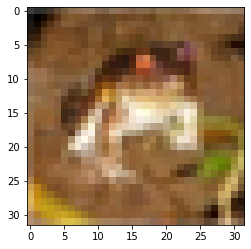

In [11]:
plt.imshow(img.permute(1, 2, 0).numpy())

Now we are ready to build our very first beam object which is the Dataset. We start by building a prototype in the notebook and later we will save it into the project .py file

First, instead of downloading and preprocessing the data each time, we will store a tensor version of both the train and the test parts of the data. If the file exists, we will directly read the data from the disk. if not, we download it and store the downloaded data as torch pickled object.

In [12]:
path = path_to_data
device = torch.device(0)

file = os.path.join(path, 'dataset_uint8.pt')
if os.path.exists(file):
    x_train, x_test, y_train, y_test = torch.load(file, map_location=device)

else:
    dataset_train = torchvision.datasets.CIFAR10(root=path, train=True,
                                                 transform=torchvision.transforms.PILToTensor(), download=True)
    dataset_test = torchvision.datasets.CIFAR10(root=path, train=False,
                                                transform=torchvision.transforms.PILToTensor(), download=True)

    x_train = torch.stack([dataset_train[i][0] for i in range(len(dataset_train))]).to(device)
    x_test = torch.stack([dataset_test[i][0] for i in range(len(dataset_test))]).to(device)

    y_train = torch.LongTensor(dataset_train.targets).to(device)
    y_test = torch.LongTensor(dataset_test.targets).to(device)

    torch.save((x_train, x_test, y_train, y_test), file)

In [13]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(x_train.device, x_test.device, y_train.device, y_test.device)
print(x_train.dtype, x_test.dtype, y_train.dtype, y_test.dtype)

torch.Size([50000, 3, 32, 32]) torch.Size([10000, 3, 32, 32]) torch.Size([50000]) torch.Size([10000])
cuda:0 cuda:0 cuda:0 cuda:0
torch.uint8 torch.uint8 torch.int64 torch.int64


The Beam Dataset object, works best with a single one-dimentional index to fetch elements from the dataset. However, in our case, we have two objects, the train and the test part. A simple solution could be to concatenate them together:

In [14]:
data = torch.cat([x_train, x_test])
labels = torch.cat([y_train, y_test])
test_indices = len(x_train) + torch.arange(len(x_test))

In this example, we also calculated the test_indices which we would like to store in order to fetch test examples.

While this solution is plausable, Beam is even more fun as it contains a PackedFolds object which is able to hold and index together multiple objects which may have different size. We can use the PackedFolds object to hold the two dataset parts, and calculate the test indices:

In [15]:
data = PackedFolds({'train': x_train, 'test': x_test})
labels = PackedFolds({'train': y_train, 'test': y_test})
test_indices = labels['test'].index

we can use the PackedFolds object to access each part of the dataset

In [16]:
data['train'].shape

torch.Size([50000, 3, 32, 32])

We can fetch and slice the data with its indices as a normal tensor. Reffer to the PackedFolds tutorial for further explenations and examples.

In [17]:
labels

{'train': tensor([6, 9, 9,  ..., 9, 1, 1], device='cuda:0'), 'test': tensor([3, 8, 8,  ..., 5, 1, 7], device='cuda:0')}

In [18]:
labels['test']

tensor([3, 8, 8,  ..., 5, 1, 7], device='cuda:0')

In [19]:
labels[40000:60000]

tensor([1, 8, 5,  ..., 5, 1, 7], device='cuda:0')

Lets build a first version of our dataset, without augmentations. We are required to write the ```__getitem__``` method that samples batches from the data for a given index vector

In [20]:
class CIFAR10Dataset(UniversalDataset):

    def __init__(self, hparams):
        
        path = hparams.path_to_data
        device = hparams.device
        
        super().__init__()

        file = os.path.join(path, 'dataset_uint8.pt')
        if os.path.exists(file):
            x_train, x_test, y_train, y_test = torch.load(file, map_location=device)

        else:
            dataset_train = torchvision.datasets.CIFAR10(root=path, train=True,
                                                         transform=torchvision.transforms.PILToTensor(), download=True)
            dataset_test = torchvision.datasets.CIFAR10(root=path, train=False,
                                                        transform=torchvision.transforms.PILToTensor(), download=True)

            x_train = torch.stack([dataset_train[i][0] for i in range(len(dataset_train))]).to(device)
            x_test = torch.stack([dataset_test[i][0] for i in range(len(dataset_test))]).to(device)

            y_train = torch.LongTensor(dataset_train.targets).to(device)
            y_test = torch.LongTensor(dataset_test.targets).to(device)

            torch.save((x_train, x_test, y_train, y_test), file)


        self.data = PackedFolds({'train': x_train, 'test': x_test})
        self.labels = PackedFolds({'train': y_train, 'test': y_test})

    def __getitem__(self, index):

        x = self.data[index]

        return {'x': x, 'y': self.labels[index]}

Notice that we passed ```hparams``` as an argument to the Dataset constructor. This will be our standard ```__init__``` format when working with beam, i.e. we pass all the arguments for the dataset in the ```hparams``` container. Now, lets make sure that we can sample a batch from this dataset:

In [21]:
dataset = CIFAR10Dataset(experiment.hparams)

In [22]:
d = dataset[10:20]
print({k: v.shape for k, v in d.items()})

{'x': torch.Size([10, 3, 32, 32]), 'y': torch.Size([10])}


while the objects ```dataset.data``` and ```dataset.labels``` contain two folds, i.e. train and test, the dataset still is not aware of the different folds and their meaning. In addition, we usually would like to split the train subset into a train-validation sets. For the dataset split purposes, beam datasets have the split method which is able to split/random split/time based split your data. It also requires a seed to generate reproducable splits. In our case, to allot 20% of the examples to the validation subset, we will call the split method as follows:

In [23]:
seed = 5782

dataset.split(validation=.2, test=dataset.labels['test'].index, seed=seed)

Now the dataset contains the ```indices_split``` dictionary which holds all the different subsets. They will be used to further generate samplers and dataloaders to iterate over the data.

In [24]:
print({k: len(v) for k, v in dataset.indices_split.items()})


{'test': 10000, 'validation': 12000, 'train': 38000}


In addition we can define different augmentations for the train/eval parts of the training. A nice property of the Beam dataset when combined with Beam algorithm is that like neural networks, it holds the ```training``` boolean property which sets the dataset in train/eval mode. The algorithm iterator toggles this property between train and eval sessions by calling ```dataset.train()``` or ```dataset.eval()``` (as with ```nn.Module``` objects). We can use this property to define different augmentations for each case.

In [25]:
class CIFAR10Dataset(UniversalDataset):

    def __init__(self, hparams, use_folds=True):
        super().__init__()

        path = hparams.path_to_data
        device = hparams.device
        padding = hparams.padding

        augmentations = transforms.Compose([transforms.RandomHorizontalFlip(),
                                            transforms.RandomCrop(32, padding=padding, padding_mode='edge'),])

        self.t_basic = transforms.Compose([transforms.Lambda(lambda x: (x / 255)),
                                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

        self.t_train = transforms.Compose([augmentations, self.t_basic])

        file = os.path.join(path, 'dataset_uint8.pt')
        if os.path.exists(file):
            x_train, x_test, y_train, y_test = torch.load(file, map_location=device)

        else:
            dataset_train = torchvision.datasets.CIFAR10(root=path, train=True,
                                                         transform=torchvision.transforms.PILToTensor(), download=True)
            dataset_test = torchvision.datasets.CIFAR10(root=path, train=False,
                                                        transform=torchvision.transforms.PILToTensor(), download=True)

            x_train = torch.stack([dataset_train[i][0] for i in range(len(dataset_train))]).to(device)
            x_test = torch.stack([dataset_test[i][0] for i in range(len(dataset_test))]).to(device)

            y_train = torch.LongTensor(dataset_train.targets).to(device)
            y_test = torch.LongTensor(dataset_test.targets).to(device)

            torch.save((x_train, x_test, y_train, y_test), file)

        if use_folds:
            self.data = PackedFolds({'train': x_train, 'test': x_test})
            self.labels = PackedFolds({'train': y_train, 'test': y_test})
            test_indices = self.labels['test'].index
        
        else:
            self.data = torch.cat([x_train, x_test])
            self.labels = torch.cat([y_train, y_test])
            test_indices = len(x_train) + torch.arange(len(x_test))
            
        self.split(validation=.2, test=test_indices, seed=hparams.split_dataset_seed)

    def __getitem__(self, index):
        x = self.data[index]

        if self.training:
            x = self.t_train(x)
        else:
            x = self.t_basic(x)

        x = x.to(memory_format=torch.channels_last)

        return {'x': x, 'y': self.labels[index]}

Notice, that we also added the ```hparams.device``` argument which defines the device for storing ```torch.Tensor``` objects in this experiemnt. Therefore, we map the data to the designated device. Finally, we added an option to work with simple tensors instead of ```PackedFolds```.

It is important to measure the fetching speed from the dataset. The most straitforward way to obtain that would be with ```tqdm```:

In [26]:
from src.beam import tqdm
batch = 128

In [27]:
dataset = CIFAR10Dataset(experiment.hparams, use_folds=True)
dataset.train()
for i in tqdm(range(10000)):
    ind = torch.randint(len(dataset), size=(batch,))
    sample = dataset[ind]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [28]:
dataset = CIFAR10Dataset(experiment.hparams, use_folds=False)
dataset.train()
for i in tqdm(range(10000)):
    ind = torch.randint(len(dataset), size=(batch,))
    sample = dataset[ind]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [29]:
dataset.data.device

device(type='cuda', index=1)

In this case we see that PackedFolds add some extra overhead to the sampling speed, however it is usually negligible when adding the neural net forward and backward passes. We can now safely use the ```PackedFolds``` option and copy our final dataset into a .py file.

In [30]:
from cifar10_example import CIFAR10Dataset

## 3. Building a neural-net

The third step of building a neural networ is not directly related to the Beam package. However, we usually comfortable with building a neural net after we have a grasp of how the dataset and the samples look like. In this stage we start to develop a prototype neural network and verify that it processes without problems our input data.

In [31]:
class ReBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1, rezero=True, activation='celu'):
        super(ReBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.rezero = rezero
        if self.rezero:
            self.resweight = self.resweight = nn.Parameter(torch.Tensor([0]), requires_grad=True)

        if activation == 'gelu':
            self.activation = nn.GELU()
        elif activation == 'celu':
            self.activation = nn.CELU()
        elif activation == 'relu':
            self.activation = nn.ReLU()

    def forward(self, x):
        out = self.activation(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # With or witout ReZero connection is after the nonlinearity
        if self.rezero == True:
            # ReZero
            out = self.resweight * self.activation(out) + x
        elif self.rezero == False:
            # Nominal
            out = self.activation(out) + x
        return out


class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight_freeze=False, bias_freeze=False, weight_init=1.0,
                 bias_init=0.0):
        super().__init__(num_features, eps=eps, momentum=momentum)
        if weight_init is not None: self.weight.data.fill_(weight_init)
        if bias_init is not None: self.bias.data.fill_(bias_init)
        self.weight.requires_grad = not weight_freeze
        self.bias.requires_grad = not bias_freeze


class Cifar10Network(nn.Module):
    """Simple Convolutional and Fully Connect network."""

    def __init__(self, channels, dropout=.0, weight=0.125, bn_weight_init=1.0, rezero=False, param_knob=None, activation='celu'):

        super().__init__()
        channels = {'prep': channels // 8, 'layer1': channels // 4, 'layer2': channels // 2, 'layer3': channels}

        if activation == 'gelu':
            self.activation = nn.GELU()
        elif activation == 'celu':
            self.activation = nn.CELU()
        elif activation == 'relu':
            self.activation = nn.ReLU()

        self.weight = weight
        self.rezero = rezero
        # Layers
        self.conv_prep = nn.Conv2d(3, channels['prep'], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_prep = BatchNorm(channels['prep'], weight_init=bn_weight_init)
        self.conv1 = nn.Conv2d(channels['prep'], channels['layer1'], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = BatchNorm(channels['layer1'], weight_init=bn_weight_init)
        self.layer1_resblock = ReBlock(channels['layer1'], channels['layer1'], rezero=self.rezero)
        self.conv2 = nn.Conv2d(channels['layer1'], channels['layer2'], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = BatchNorm(channels['layer2'], weight_init=bn_weight_init)
        self.conv3 = nn.Conv2d(channels['layer2'], channels['layer3'], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = BatchNorm(channels['layer3'], weight_init=bn_weight_init)
        self.layer3_resblock = ReBlock(channels['layer3'], channels['layer3'], rezero=self.rezero)
        self.pool = nn.MaxPool2d(2)
        self.classifier_pool = nn.MaxPool2d(4)
        self.classifier_fc = nn.Linear(channels['layer3'], 10, bias=False)

    def forward(self, x):
        # cuda0 = torch.device('cuda:0')
        """Compute a forward pass."""
        # Prep
        x = self.activation(self.bn_prep(self.conv_prep(x)))
        x = self.activation(self.bn1(self.pool(self.conv1(x))))
        x = self.layer1_resblock(x)
        x = self.activation(self.bn2(self.pool(self.conv2(x))))
        x = self.activation(self.bn3(self.pool(self.conv3(x))))
        x = self.layer3_resblock(x)
        # Classifier
        x = self.classifier_pool(x)
        x = x.view(x.size(0), x.size(1))
        x = self.classifier_fc(x)
        x = x * self.weight
        return x

Lets build a neural-network based on our model and the experiment hyperparameters and pass it to the experiment device. 

In [32]:
net = Cifar10Network(channels=hparams.channels, 
                     dropout=hparams.dropout, 
                     weight=hparams.temperature, 
                     bn_weight_init=1.0, 
                     rezero=False, 
                     param_knob=None, 
                     activation=hparams.activation).to(experiment.hparams.device)

Notice that when we wish to refer to the experiment device it is better to call ```experiment.hparams.device``` instead of the original argument ```hparams.device``` as the experiment class transforms the string argument into a ```torch.device``` type.

In [33]:
experiment.hparams.device

device(type='cuda', index=1)

In [34]:
hparams.device

'0'

Lets verify that the model accepts batch of cifar10 images and returns the 10 classes pre softmax probabilities

In [35]:
dataset = CIFAR10Dataset(experiment.hparams)
batch = 128

ind = torch.randint(len(dataset), size=(batch,))
sample = dataset[ind]
x = sample['x']
y = net(x)

In [36]:
print(x.shape, y.shape)

torch.Size([128, 3, 32, 32]) torch.Size([128, 10])


We will now copy the neural-net class to our project .py file and continue with building our last beam part which is the algorithm.

In [37]:
from cifar10_example import Cifar10Network

## 4. Building an algorithm

### Writing an iteration loop

Before building the Algorithm class, we can try and verify that our inner loop is working as expected. In simple algorithms, this part can be realy simple but sometimes, when developing GANs for example we might want to make sure that the inner loop works as expected.

In [38]:
dataset = CIFAR10Dataset(experiment.hparams)
net = Cifar10Network(channels=hparams.channels, 
                     dropout=hparams.dropout, 
                     weight=hparams.temperature, 
                     bn_weight_init=1.0, 
                     rezero=False, 
                     param_knob=None, 
                     activation=hparams.activation).to(experiment.hparams.device)

In this part we can also try out our optimizer. Beam offers a ```BeamOptimizer``` class which add some functionalities to the defaul pytorch optimizer. First, it supports mixed model with both sparse and dense gradients as it applies sparse optimizer to the sparse parameters and dense optimizer to the dense parameters (The default sparse optimizer is ```SparseAdam``` and the default dense optimizer is ```AdamW```). In addition, it supports automatic mixed precision calculation and it can clip the gradient and accumulate the gradients to simulate large batches.

In [39]:
opt = BeamOptimizer(net, dense_args={'lr': hparams.lr_dense,
                                                        'weight_decay': hparams.weight_decay,
                                                       'momentum': hparams.beta1, 'nesterov': True},
                                            clip=hparams.clip_gradient, accumulate=hparams.accumulate,
                                            amp=hparams.amp,
                                            sparse_args=None, dense_optimizer='SGD')

In our case we replaced the default dense optimizer ```AdamW``` with the simpler ```SGD``` optimizer as in CIFAR10, it yields better results when learning with a limited number of epochs.

In [40]:
# our inner loop

ind = torch.randint(len(dataset), size=(batch,))
sample = dataset[ind]

x, y = sample['x'], sample['y']

y_hat = net(x)
loss = F.cross_entropy(y_hat, y, reduction='sum', label_smoothing=hparams.label_smoothing)

opt.apply(loss, training=True)

### Building an algorithm based on the iteration loop.

After verifing our inner loop we can start building an Algorithm class. In this example we will start from a minimal implementation and gradually add some complexities.

In [41]:
class CIFAR10Algorithm(Algorithm):

    def __init__(self, hparams):

        net = Cifar10Network(hparams.channels, dropout=hparams.dropout,
                             activation=hparams.activation, weight=hparams.temperature)

        optimizer = BeamOptimizer.prototype(dense_args={'lr': hparams.lr_dense,
                                                        'weight_decay': hparams.weight_decay,
                                                       'momentum': hparams.beta1, 'nesterov': True},
                                            clip=hparams.clip_gradient, accumulate=hparams.accumulate,
                                            amp=hparams.amp,
                                            sparse_args=None, dense_optimizer='SGD')
        
        # optimizer = BeamOptimizer(net, dense_args={'lr': hparams.lr_dense,
        #                                         'weight_decay': hparams.weight_decay,
        #                                        'momentum': hparams.beta1, 'nesterov': True},
        #                             clip=hparams.clip_gradient, accumulate=hparams.accumulate,
        #                             amp=hparams.amp,
        #                             sparse_args=None, dense_optimizer='SGD')

        super().__init__(hparams, networks=net, optimizers=optimizer)


    def iteration(self, sample=None, results=None, counter=None, subset=None, training=True):

        x, y = sample['x'], sample['y']

        net = self.networks['net']
        opt = self.optimizers['net']

        y_hat = net(x)
        loss = F.cross_entropy(y_hat, y, reduction='sum', label_smoothing=self.hparams.label_smoothing)

        opt.apply(loss, training=training)

        # add scalar measurements
        results['scalar']['loss'].append(float(loss))
        results['scalar']['acc'].append(float((y_hat.argmax(1) == y).float().mean()))

        return results
    

It is important to undestand how 

Lets generate new hyperparameters, this time to avoid long experiments we will choose to train only for 4 epochs.

In [4]:
hparams = beam_arguments(get_cifar10_parser(), f"--project-name=cifar10 --root-dir=/tmp/cifar --algorithm=CIFAR10Algorithm --device=0 --amp --lr-d=1e-2 --batch-size=512",
                      "--n-epochs=4 --clip-gradient=1000 --parallel=2 --accumulate=1 --no-deterministic",
                      "--weight-decay=3e-5 --beta1=0.9")

Lets call a new experiment instance. We can avoid printing all the hyperparameters by setting the argument ```print_hyperparameters=False```

In [5]:
experiment = Experiment(hparams, print_hyperparameters=False)

2022-07-12 13:32:36 | INFO     | Creating new experiment
2022-07-12 13:32:36 | INFO     | Experiment directory is: /tmp/cifar/cifar10/CIFAR10Algorithm/debug/0034_20220712_133236


In [6]:

from cifar10_example import CIFAR10Algorithm

In [7]:
alg = experiment.fit(CIFAR10Algorithm, CIFAR10Dataset)

NameError: name 'CIFAR10Dataset' is not defined

In [4]:
from cifar10_example import Cifar10Network
from cifar10_example import CIFAR10Algorithm
from cifar10_example import CIFAR10Dataset

Lets call a new experiment instance. We can avoid printing all the hyperparameters by setting the argument ```print_hyperparameters=False```

In [19]:
hparams = beam_arguments(get_cifar10_parser(), f"--project-name=cifar10 --root-dir=/tmp/cifar --algorithm=CIFAR10Algorithm --device=0 --amp --lr-d=1e-2 --batch-size=512",
                      "--n-epochs=40 --identifier=compare_parallel --clip-gradient=1000 --parallel=2 --accumulate=1 --no-deterministic",
                      "--weight-decay=3e-5 --beta1=0.9", prototype=False)
experiment = Experiment(hparams, print_hyperparameters=False)
alg = experiment.fit(CIFAR10Algorithm, CIFAR10Dataset)

2022-07-12 13:40:07 | INFO     | Creating new experiment
2022-07-12 13:40:07 | INFO     | Experiment directory is: /tmp/cifar/cifar10/CIFAR10Algorithm/compare_parallel/0000_20220712_134007
2022-07-12 13:40:07 | INFO     | Initializing 2 parallel workers
2022-07-12 13:40:07 | INFO     | Multiprocessing port is: 48513
2022-07-12 13:40:10 | INFO     | Worker: 1/2 is running...
2022-07-12 13:40:10 | INFO     | Worker: 2/2 is running...


2022-07-12 13:40:18.096677: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
train:   0%|          | 0/73 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
validation: 100%|██████████| 22/22 [00:00<00:00, 35.55it/s]

2022-07-12 13:40:31 | INFO     | 
2022-07-12 13:40:31 | INFO     | Finished epoch 1/40:
2022-07-12 13:40:31 | INFO     | train:
2022-07-12 13:40:31 | INFO     | loss:           | avg: 916.2     | std: 123.4     | min: 734.0     | 25%: 812.7     | 50%: 890.1     | 75%: 979.7     | max: 1.182e+03 
2022-07-12 13:40:31 | INFO     | acc:            | avg: 0.4682    | std: 0.1628    | min: 0.05664   | 25%: 0.3887    | 50%: 0.502     | 75%: 0.5957    | max: 0.7168    
2022-07-12 13:40:31 | INFO     | lr:             | avg: 0.0005    | std: nan       | min: 0.0005    | 25%: 0.0005    | 50%: 0.0005    | 75%: 0.0005    | max: 0.0005    
2022-07-12 13:40:31 | INFO     | validation:
2022-07-12 13:40:31 | INFO     | loss:           | avg: 793.9     | std: 15.02     | min: 767.3     | 25%: 782.3     | 50%: 798.6     | 75%: 802.2     | max: 824.5     
2022-07-12 13:40:31 | INFO     | acc:            | avg: 0.6197    | std: 0.02455   | min: 0.5781    | 25%: 0.6021    | 50%: 0.6143    | 75%: 0.6323    


validation: 100%|██████████| 22/22 [00:00<00:00, 35.33it/s]

2022-07-12 13:40:43 | INFO     | 
2022-07-12 13:40:43 | INFO     | Finished epoch 2/40:
2022-07-12 13:40:43 | INFO     | train:
2022-07-12 13:40:43 | INFO     | loss:           | avg: 691.3     | std: 34.47     | min: 632.7     | 25%: 660.2     | 50%: 688.4     | 75%: 715.2     | max: 779.8     
2022-07-12 13:40:43 | INFO     | acc:            | avg: 0.7554    | std: 0.04706   | min: 0.625     | 25%: 0.7266    | 50%: 0.7617    | 75%: 0.7871    | max: 0.8496    
2022-07-12 13:40:43 | INFO     | lr:             | avg: 0.0005703 | std: nan       | min: 0.0005703 | 25%: 0.0005703 | 50%: 0.0005703 | 75%: 0.0005703 | max: 0.0005703 
2022-07-12 13:40:43 | INFO     | validation:
2022-07-12 13:40:43 | INFO     | loss:           | avg: 691.3     | std: 8.848     | min: 671.4     | 25%: 685.7     | 50%: 692.2     | 75%: 698.5     | max: 706.0     
2022-07-12 13:40:43 | INFO     | acc:            | avg: 0.7589    | std: 0.01464   | min: 0.7402    | 25%: 0.7485    | 50%: 0.7578    | 75%: 0.7632    


validation: 100%|██████████| 22/22 [00:00<00:00, 35.27it/s]

2022-07-12 13:40:55 | INFO     | 
2022-07-12 13:40:55 | INFO     | Finished epoch 3/40:
2022-07-12 13:40:55 | INFO     | train:
2022-07-12 13:40:55 | INFO     | loss:           | avg: 626.5     | std: 16.7      | min: 590.9     | 25%: 616.7     | 50%: 624.9     | 75%: 639.7     | max: 660.0     
2022-07-12 13:40:55 | INFO     | acc:            | avg: 0.8319    | std: 0.02213   | min: 0.7832    | 25%: 0.8164    | 50%: 0.834     | 75%: 0.8457    | max: 0.8809    
2022-07-12 13:40:55 | INFO     | lr:             | avg: 0.0008555 | std: nan       | min: 0.0008555 | 25%: 0.0008555 | 50%: 0.0008555 | 75%: 0.0008555 | max: 0.0008555 
2022-07-12 13:40:55 | INFO     | validation:
2022-07-12 13:40:55 | INFO     | loss:           | avg: 642.8     | std: 10.32     | min: 623.1     | 25%: 636.4     | 50%: 642.2     | 75%: 648.6     | max: 665.7     
2022-07-12 13:40:55 | INFO     | acc:            | avg: 0.8126    | std: 0.01817   | min: 0.7617    | 25%: 0.8003    | 50%: 0.8135    | 75%: 0.8262    


validation: 100%|██████████| 22/22 [00:00<00:00, 35.15it/s]

2022-07-12 13:41:08 | INFO     | 
2022-07-12 13:41:08 | INFO     | Finished epoch 4/40:
2022-07-12 13:41:08 | INFO     | train:
2022-07-12 13:41:08 | INFO     | loss:           | avg: 592.6     | std: 13.22     | min: 555.4     | 25%: 585.3     | 50%: 594.5     | 75%: 601.3     | max: 624.5     
2022-07-12 13:41:08 | INFO     | acc:            | avg: 0.8691    | std: 0.01874   | min: 0.834     | 25%: 0.8574    | 50%: 0.8672    | 75%: 0.8828    | max: 0.918     
2022-07-12 13:41:08 | INFO     | lr:             | avg: 0.001141  | std: nan       | min: 0.001141  | 25%: 0.001141  | 50%: 0.001141  | 75%: 0.001141  | max: 0.001141  
2022-07-12 13:41:08 | INFO     | validation:
2022-07-12 13:41:08 | INFO     | loss:           | avg: 604.2     | std: 9.834     | min: 588.8     | 25%: 598.3     | 50%: 603.6     | 75%: 609.1     | max: 629.3     
2022-07-12 13:41:08 | INFO     | acc:            | avg: 0.8532    | std: 0.0158    | min: 0.8262    | 25%: 0.8457    | 50%: 0.8516    | 75%: 0.8623    


validation: 100%|██████████| 22/22 [00:00<00:00, 35.08it/s]

2022-07-12 13:41:20 | INFO     | 
2022-07-12 13:41:20 | INFO     | Finished epoch 5/40:
2022-07-12 13:41:20 | INFO     | train:
2022-07-12 13:41:20 | INFO     | loss:           | avg: 564.1     | std: 16.49     | min: 535.8     | 25%: 553.9     | 50%: 562.9     | 75%: 569.3     | max: 637.1     
2022-07-12 13:41:20 | INFO     | acc:            | avg: 0.8994    | std: 0.02176   | min: 0.8086    | 25%: 0.8887    | 50%: 0.9023    | 75%: 0.9121    | max: 0.9395    
2022-07-12 13:41:20 | INFO     | lr:             | avg: 0.001426  | std: nan       | min: 0.001426  | 25%: 0.001426  | 50%: 0.001426  | 75%: 0.001426  | max: 0.001426  
2022-07-12 13:41:20 | INFO     | validation:
2022-07-12 13:41:20 | INFO     | loss:           | avg: 590.5     | std: 11.68     | min: 569.5     | 25%: 584.8     | 50%: 588.7     | 75%: 597.1     | max: 612.2     
2022-07-12 13:41:20 | INFO     | acc:            | avg: 0.8737    | std: 0.01612   | min: 0.8438    | 25%: 0.8638    | 50%: 0.874     | 75%: 0.8853    


validation: 100%|██████████| 22/22 [00:00<00:00, 34.62it/s]

2022-07-12 13:41:33 | INFO     | 
2022-07-12 13:41:33 | INFO     | Finished epoch 6/40:
2022-07-12 13:41:33 | INFO     | train:
2022-07-12 13:41:33 | INFO     | loss:           | avg: 547.2     | std: 13.02     | min: 528.2     | 25%: 537.5     | 50%: 544.8     | 75%: 554.6     | max: 600.7     
2022-07-12 13:41:33 | INFO     | acc:            | avg: 0.9159    | std: 0.01795   | min: 0.8516    | 25%: 0.9082    | 50%: 0.918     | 75%: 0.9277    | max: 0.9492    
2022-07-12 13:41:33 | INFO     | lr:             | avg: 0.001711  | std: nan       | min: 0.001711  | 25%: 0.001711  | 50%: 0.001711  | 75%: 0.001711  | max: 0.001711  
2022-07-12 13:41:33 | INFO     | validation:
2022-07-12 13:41:33 | INFO     | loss:           | avg: 641.9     | std: 15.69     | min: 611.2     | 25%: 632.5     | 50%: 645.9     | 75%: 652.9     | max: 670.9     
2022-07-12 13:41:33 | INFO     | acc:            | avg: 0.8156    | std: 0.01779   | min: 0.7832    | 25%: 0.8086    | 50%: 0.8135    | 75%: 0.8198    


validation: 100%|██████████| 22/22 [00:00<00:00, 34.40it/s]

2022-07-12 13:41:45 | INFO     | 
2022-07-12 13:41:45 | INFO     | Finished epoch 7/40:
2022-07-12 13:41:45 | INFO     | train:
2022-07-12 13:41:45 | INFO     | loss:           | avg: 531.1     | std: 12.84     | min: 504.3     | 25%: 523.8     | 50%: 528.8     | 75%: 536.3     | max: 569.3     
2022-07-12 13:41:45 | INFO     | acc:            | avg: 0.9348    | std: 0.01668   | min: 0.8809    | 25%: 0.9258    | 50%: 0.9375    | 75%: 0.9473    | max: 0.9668    
2022-07-12 13:41:45 | INFO     | lr:             | avg: 0.001996  | std: nan       | min: 0.001996  | 25%: 0.001996  | 50%: 0.001996  | 75%: 0.001996  | max: 0.001996  
2022-07-12 13:41:45 | INFO     | validation:
2022-07-12 13:41:45 | INFO     | loss:           | avg: 604.4     | std: 11.74     | min: 571.6     | 25%: 597.2     | 50%: 604.6     | 75%: 614.0     | max: 621.6     
2022-07-12 13:41:45 | INFO     | acc:            | avg: 0.8517    | std: 0.0157    | min: 0.8223    | 25%: 0.8398    | 50%: 0.8496    | 75%: 0.8608    


validation: 100%|██████████| 22/22 [00:00<00:00, 34.28it/s]

2022-07-12 13:41:58 | INFO     | 
2022-07-12 13:41:58 | INFO     | Finished epoch 8/40:
2022-07-12 13:41:58 | INFO     | train:
2022-07-12 13:41:58 | INFO     | loss:           | avg: 513.2     | std: 10.79     | min: 490.7     | 25%: 504.0     | 50%: 514.9     | 75%: 518.5     | max: 542.0     
2022-07-12 13:41:58 | INFO     | acc:            | avg: 0.9533    | std: 0.01233   | min: 0.9082    | 25%: 0.9473    | 50%: 0.9531    | 75%: 0.9629    | max: 0.9766    
2022-07-12 13:41:58 | INFO     | lr:             | avg: 0.00196   | std: nan       | min: 0.00196   | 25%: 0.00196   | 50%: 0.00196   | 75%: 0.00196   | max: 0.00196   
2022-07-12 13:41:58 | INFO     | validation:
2022-07-12 13:41:58 | INFO     | loss:           | avg: 573.9     | std: 9.256     | min: 557.9     | 25%: 567.1     | 50%: 573.0     | 75%: 579.8     | max: 596.1     
2022-07-12 13:41:58 | INFO     | acc:            | avg: 0.8918    | std: 0.01366   | min: 0.8672    | 25%: 0.8813    | 50%: 0.8906    | 75%: 0.9023    


validation: 100%|██████████| 22/22 [00:00<00:00, 34.38it/s]

2022-07-12 13:42:10 | INFO     | 
2022-07-12 13:42:10 | INFO     | Finished epoch 9/40:
2022-07-12 13:42:10 | INFO     | train:
2022-07-12 13:42:10 | INFO     | loss:           | avg: 496.6     | std: 7.706     | min: 480.5     | 25%: 491.2     | 50%: 496.3     | 75%: 502.2     | max: 514.5     
2022-07-12 13:42:10 | INFO     | acc:            | avg: 0.9674    | std: 0.009818  | min: 0.9434    | 25%: 0.9609    | 50%: 0.9688    | 75%: 0.9746    | max: 0.9883    
2022-07-12 13:42:10 | INFO     | lr:             | avg: 0.001919  | std: nan       | min: 0.001919  | 25%: 0.001919  | 50%: 0.001919  | 75%: 0.001919  | max: 0.001919  
2022-07-12 13:42:10 | INFO     | validation:
2022-07-12 13:42:10 | INFO     | loss:           | avg: 570.4     | std: 13.25     | min: 547.6     | 25%: 563.4     | 50%: 569.0     | 75%: 579.7     | max: 608.0     
2022-07-12 13:42:10 | INFO     | acc:            | avg: 0.8825    | std: 0.01282   | min: 0.8496    | 25%: 0.8774    | 50%: 0.8848    | 75%: 0.8887    


validation: 100%|██████████| 22/22 [00:00<00:00, 33.77it/s]

2022-07-12 13:42:23 | INFO     | 
2022-07-12 13:42:23 | INFO     | Finished epoch 10/40:
2022-07-12 13:42:23 | INFO     | train:
2022-07-12 13:42:23 | INFO     | loss:           | avg: 486.0     | std: 7.005     | min: 474.4     | 25%: 480.1     | 50%: 485.0     | 75%: 491.0     | max: 507.0     
2022-07-12 13:42:23 | INFO     | acc:            | avg: 0.9762    | std: 0.009052  | min: 0.9492    | 25%: 0.9707    | 50%: 0.9785    | 75%: 0.9824    | max: 0.9902    
2022-07-12 13:42:23 | INFO     | lr:             | avg: 0.001878  | std: nan       | min: 0.001878  | 25%: 0.001878  | 50%: 0.001878  | 75%: 0.001878  | max: 0.001878  
2022-07-12 13:42:23 | INFO     | validation:
2022-07-12 13:42:23 | INFO     | loss:           | avg: 551.5     | std: 9.122     | min: 531.4     | 25%: 545.6     | 50%: 553.3     | 75%: 557.0     | max: 565.4     
2022-07-12 13:42:23 | INFO     | acc:            | avg: 0.898     | std: 0.01128   | min: 0.8789    | 25%: 0.8892    | 50%: 0.8984    | 75%: 0.9023   


validation: 100%|██████████| 22/22 [00:00<00:00, 34.48it/s]

2022-07-12 13:42:35 | INFO     | 
2022-07-12 13:42:35 | INFO     | Finished epoch 11/40:
2022-07-12 13:42:35 | INFO     | train:
2022-07-12 13:42:35 | INFO     | loss:           | avg: 477.5     | std: 7.161     | min: 463.7     | 25%: 472.0     | 50%: 476.9     | 75%: 481.3     | max: 505.6     
2022-07-12 13:42:35 | INFO     | acc:            | avg: 0.9844    | std: 0.007682  | min: 0.9551    | 25%: 0.9805    | 50%: 0.9863    | 75%: 0.9902    | max: 0.998     
2022-07-12 13:42:35 | INFO     | lr:             | avg: 0.001838  | std: nan       | min: 0.001838  | 25%: 0.001838  | 50%: 0.001838  | 75%: 0.001838  | max: 0.001838  
2022-07-12 13:42:35 | INFO     | validation:
2022-07-12 13:42:35 | INFO     | loss:           | avg: 531.5     | std: 10.88     | min: 513.7     | 25%: 523.1     | 50%: 530.7     | 75%: 540.5     | max: 549.6     
2022-07-12 13:42:35 | INFO     | acc:            | avg: 0.9186    | std: 0.01451   | min: 0.8887    | 25%: 0.9048    | 50%: 0.9199    | 75%: 0.9312   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.48it/s]

2022-07-12 13:42:48 | INFO     | 
2022-07-12 13:42:48 | INFO     | Finished epoch 12/40:
2022-07-12 13:42:48 | INFO     | train:
2022-07-12 13:42:48 | INFO     | loss:           | avg: 469.7     | std: 5.272     | min: 460.1     | 25%: 466.3     | 50%: 468.7     | 75%: 473.3     | max: 487.4     
2022-07-12 13:42:48 | INFO     | acc:            | avg: 0.9902    | std: 0.005814  | min: 0.9688    | 25%: 0.9863    | 50%: 0.9902    | 75%: 0.9941    | max: 1.0       
2022-07-12 13:42:48 | INFO     | lr:             | avg: 0.001797  | std: nan       | min: 0.001797  | 25%: 0.001797  | 50%: 0.001797  | 75%: 0.001797  | max: 0.001797  
2022-07-12 13:42:48 | INFO     | validation:
2022-07-12 13:42:48 | INFO     | loss:           | avg: 527.9     | std: 7.982     | min: 514.5     | 25%: 523.8     | 50%: 527.5     | 75%: 531.3     | max: 548.8     
2022-07-12 13:42:48 | INFO     | acc:            | avg: 0.9212    | std: 0.0104    | min: 0.9023    | 25%: 0.9126    | 50%: 0.9229    | 75%: 0.9292   


validation: 100%|██████████| 22/22 [00:00<00:00, 34.22it/s]

2022-07-12 13:43:03 | INFO     | 
2022-07-12 13:43:03 | INFO     | Finished epoch 13/40:
2022-07-12 13:43:03 | INFO     | train:
2022-07-12 13:43:03 | INFO     | loss:           | avg: 464.7     | std: 5.023     | min: 457.3     | 25%: 460.9     | 50%: 463.5     | 75%: 467.6     | max: 482.0     
2022-07-12 13:43:03 | INFO     | acc:            | avg: 0.9924    | std: 0.005224  | min: 0.9766    | 25%: 0.9902    | 50%: 0.9941    | 75%: 0.9961    | max: 1.0       
2022-07-12 13:43:03 | INFO     | lr:             | avg: 0.001756  | std: nan       | min: 0.001756  | 25%: 0.001756  | 50%: 0.001756  | 75%: 0.001756  | max: 0.001756  
2022-07-12 13:43:03 | INFO     | validation:
2022-07-12 13:43:03 | INFO     | loss:           | avg: 527.6     | std: 11.16     | min: 505.0     | 25%: 523.5     | 50%: 527.6     | 75%: 531.9     | max: 551.9     
2022-07-12 13:43:03 | INFO     | acc:            | avg: 0.9205    | std: 0.01434   | min: 0.8848    | 25%: 0.9126    | 50%: 0.9209    | 75%: 0.9321   


validation: 100%|██████████| 22/22 [00:00<00:00, 34.40it/s]

2022-07-12 13:43:17 | INFO     | 
2022-07-12 13:43:17 | INFO     | Finished epoch 14/40:
2022-07-12 13:43:17 | INFO     | train:
2022-07-12 13:43:17 | INFO     | loss:           | avg: 459.7     | std: 3.561     | min: 453.6     | 25%: 457.0     | 50%: 459.1     | 75%: 462.1     | max: 471.8     
2022-07-12 13:43:17 | INFO     | acc:            | avg: 0.9969    | std: 0.002946  | min: 0.9902    | 25%: 0.9941    | 50%: 0.998     | 75%: 1.0       | max: 1.0       
2022-07-12 13:43:17 | INFO     | lr:             | avg: 0.001715  | std: nan       | min: 0.001715  | 25%: 0.001715  | 50%: 0.001715  | 75%: 0.001715  | max: 0.001715  
2022-07-12 13:43:17 | INFO     | validation:
2022-07-12 13:43:17 | INFO     | loss:           | avg: 523.5     | std: 9.782     | min: 501.2     | 25%: 519.2     | 50%: 524.4     | 75%: 530.2     | max: 538.8     
2022-07-12 13:43:17 | INFO     | acc:            | avg: 0.9238    | std: 0.01132   | min: 0.9043    | 25%: 0.9185    | 50%: 0.9229    | 75%: 0.9272   


validation: 100%|██████████| 22/22 [00:00<00:00, 34.72it/s]

2022-07-12 13:43:32 | INFO     | 
2022-07-12 13:43:32 | INFO     | Finished epoch 15/40:
2022-07-12 13:43:32 | INFO     | train:
2022-07-12 13:43:32 | INFO     | loss:           | avg: 457.5     | std: 3.242     | min: 452.8     | 25%: 455.1     | 50%: 456.6     | 75%: 459.8     | max: 470.5     
2022-07-12 13:43:32 | INFO     | acc:            | avg: 0.9971    | std: 0.003056  | min: 0.9805    | 25%: 0.9961    | 50%: 0.998     | 75%: 0.998     | max: 1.0       
2022-07-12 13:43:32 | INFO     | lr:             | avg: 0.001675  | std: nan       | min: 0.001675  | 25%: 0.001675  | 50%: 0.001675  | 75%: 0.001675  | max: 0.001675  
2022-07-12 13:43:32 | INFO     | validation:
2022-07-12 13:43:32 | INFO     | loss:           | avg: 523.6     | std: 6.237     | min: 510.2     | 25%: 519.9     | 50%: 522.9     | 75%: 528.4     | max: 534.3     
2022-07-12 13:43:32 | INFO     | acc:            | avg: 0.9267    | std: 0.01004   | min: 0.9082    | 25%: 0.9219    | 50%: 0.9287    | 75%: 0.9316   


validation: 100%|██████████| 22/22 [00:00<00:00, 34.48it/s]

2022-07-12 13:43:47 | INFO     | 
2022-07-12 13:43:47 | INFO     | Finished epoch 16/40:
2022-07-12 13:43:47 | INFO     | train:
2022-07-12 13:43:47 | INFO     | loss:           | avg: 455.1     | std: 3.135     | min: 451.0     | 25%: 453.0     | 50%: 454.2     | 75%: 456.6     | max: 466.1     
2022-07-12 13:43:47 | INFO     | acc:            | avg: 0.9981    | std: 0.00249   | min: 0.9883    | 25%: 0.998     | 50%: 0.998     | 75%: 1.0       | max: 1.0       
2022-07-12 13:43:47 | INFO     | lr:             | avg: 0.001634  | std: nan       | min: 0.001634  | 25%: 0.001634  | 50%: 0.001634  | 75%: 0.001634  | max: 0.001634  
2022-07-12 13:43:47 | INFO     | validation:
2022-07-12 13:43:47 | INFO     | loss:           | avg: 522.5     | std: 9.365     | min: 508.2     | 25%: 516.9     | 50%: 521.6     | 75%: 527.4     | max: 544.0     
2022-07-12 13:43:47 | INFO     | acc:            | avg: 0.9266    | std: 0.01168   | min: 0.8984    | 25%: 0.9189    | 50%: 0.9287    | 75%: 0.9336   


validation: 100%|██████████| 22/22 [00:00<00:00, 34.67it/s]

2022-07-12 13:44:00 | INFO     | 
2022-07-12 13:44:00 | INFO     | Finished epoch 17/40:
2022-07-12 13:44:00 | INFO     | train:
2022-07-12 13:44:00 | INFO     | loss:           | avg: 453.9     | std: 2.624     | min: 450.4     | 25%: 452.1     | 50%: 453.3     | 75%: 454.9     | max: 464.2     
2022-07-12 13:44:00 | INFO     | acc:            | avg: 0.9987    | std: 0.002086  | min: 0.9883    | 25%: 0.998     | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:44:00 | INFO     | lr:             | avg: 0.001593  | std: nan       | min: 0.001593  | 25%: 0.001593  | 50%: 0.001593  | 75%: 0.001593  | max: 0.001593  
2022-07-12 13:44:00 | INFO     | validation:
2022-07-12 13:44:00 | INFO     | loss:           | avg: 518.3     | std: 8.454     | min: 506.7     | 25%: 511.4     | 50%: 516.6     | 75%: 525.3     | max: 535.7     
2022-07-12 13:44:00 | INFO     | acc:            | avg: 0.9304    | std: 0.0102    | min: 0.9102    | 25%: 0.9243    | 50%: 0.9326    | 75%: 0.9355   


validation: 100%|██████████| 22/22 [00:00<00:00, 34.29it/s]

2022-07-12 13:44:12 | INFO     | 
2022-07-12 13:44:12 | INFO     | Finished epoch 18/40:
2022-07-12 13:44:12 | INFO     | train:
2022-07-12 13:44:12 | INFO     | loss:           | avg: 451.7     | std: 1.884     | min: 448.9     | 25%: 450.4     | 50%: 451.4     | 75%: 452.6     | max: 458.2     
2022-07-12 13:44:12 | INFO     | acc:            | avg: 0.9993    | std: 0.001311  | min: 0.9941    | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:44:12 | INFO     | lr:             | avg: 0.001552  | std: nan       | min: 0.001552  | 25%: 0.001552  | 50%: 0.001552  | 75%: 0.001552  | max: 0.001552  
2022-07-12 13:44:12 | INFO     | validation:
2022-07-12 13:44:12 | INFO     | loss:           | avg: 527.8     | std: 10.32     | min: 507.2     | 25%: 521.0     | 50%: 526.9     | 75%: 532.6     | max: 552.6     
2022-07-12 13:44:12 | INFO     | acc:            | avg: 0.9304    | std: 0.01235   | min: 0.9004    | 25%: 0.9224    | 50%: 0.9316    | 75%: 0.9395   


validation: 100%|██████████| 22/22 [00:00<00:00, 34.05it/s]

2022-07-12 13:44:25 | INFO     | 
2022-07-12 13:44:25 | INFO     | Finished epoch 19/40:
2022-07-12 13:44:25 | INFO     | train:
2022-07-12 13:44:25 | INFO     | loss:           | avg: 451.2     | std: 2.147     | min: 448.4     | 25%: 449.7     | 50%: 450.9     | 75%: 452.2     | max: 458.9     
2022-07-12 13:44:25 | INFO     | acc:            | avg: 0.9994    | std: 0.001563  | min: 0.9902    | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:44:25 | INFO     | lr:             | avg: 0.001512  | std: nan       | min: 0.001512  | 25%: 0.001512  | 50%: 0.001512  | 75%: 0.001512  | max: 0.001512  
2022-07-12 13:44:25 | INFO     | validation:
2022-07-12 13:44:25 | INFO     | loss:           | avg: 513.7     | std: 7.081     | min: 499.8     | 25%: 509.6     | 50%: 513.9     | 75%: 517.5     | max: 527.2     
2022-07-12 13:44:25 | INFO     | acc:            | avg: 0.9373    | std: 0.01014   | min: 0.916     | 25%: 0.9297    | 50%: 0.9365    | 75%: 0.9443   


validation: 100%|██████████| 22/22 [00:00<00:00, 34.29it/s]

2022-07-12 13:44:38 | INFO     | 
2022-07-12 13:44:38 | INFO     | Finished epoch 20/40:
2022-07-12 13:44:38 | INFO     | train:
2022-07-12 13:44:38 | INFO     | loss:           | avg: 450.0     | std: 1.486     | min: 447.5     | 25%: 448.8     | 50%: 449.8     | 75%: 451.0     | max: 454.6     
2022-07-12 13:44:38 | INFO     | acc:            | avg: 0.9995    | std: 0.0009502 | min: 0.9961    | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:44:38 | INFO     | lr:             | avg: 0.001471  | std: nan       | min: 0.001471  | 25%: 0.001471  | 50%: 0.001471  | 75%: 0.001471  | max: 0.001471  
2022-07-12 13:44:38 | INFO     | validation:
2022-07-12 13:44:38 | INFO     | loss:           | avg: 515.6     | std: 7.645     | min: 501.9     | 25%: 509.7     | 50%: 517.4     | 75%: 520.5     | max: 532.5     
2022-07-12 13:44:38 | INFO     | acc:            | avg: 0.9339    | std: 0.01054   | min: 0.9082    | 25%: 0.9268    | 50%: 0.9365    | 75%: 0.9395   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.88it/s]

2022-07-12 13:44:50 | INFO     | 
2022-07-12 13:44:50 | INFO     | Finished epoch 21/40:
2022-07-12 13:44:50 | INFO     | train:
2022-07-12 13:44:50 | INFO     | loss:           | avg: 449.5     | std: 1.528     | min: 447.2     | 25%: 448.5     | 50%: 448.9     | 75%: 450.2     | max: 455.3     
2022-07-12 13:44:50 | INFO     | acc:            | avg: 0.9996    | std: 0.001063  | min: 0.9941    | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:44:50 | INFO     | lr:             | avg: 0.00143   | std: nan       | min: 0.00143   | 25%: 0.00143   | 50%: 0.00143   | 75%: 0.00143   | max: 0.00143   
2022-07-12 13:44:50 | INFO     | validation:
2022-07-12 13:44:50 | INFO     | loss:           | avg: 513.7     | std: 9.874     | min: 497.5     | 25%: 510.7     | 50%: 513.4     | 75%: 518.5     | max: 534.3     
2022-07-12 13:44:50 | INFO     | acc:            | avg: 0.9344    | std: 0.01137   | min: 0.9121    | 25%: 0.9282    | 50%: 0.9355    | 75%: 0.9419   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.95it/s]

2022-07-12 13:45:03 | INFO     | 
2022-07-12 13:45:03 | INFO     | Finished epoch 22/40:
2022-07-12 13:45:03 | INFO     | train:
2022-07-12 13:45:03 | INFO     | loss:           | avg: 448.6     | std: 1.121     | min: 446.9     | 25%: 447.8     | 50%: 448.3     | 75%: 449.1     | max: 451.5     
2022-07-12 13:45:03 | INFO     | acc:            | avg: 0.9999    | std: 0.0004968 | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:45:03 | INFO     | lr:             | avg: 0.00139   | std: nan       | min: 0.00139   | 25%: 0.00139   | 50%: 0.00139   | 75%: 0.00139   | max: 0.00139   
2022-07-12 13:45:03 | INFO     | validation:
2022-07-12 13:45:03 | INFO     | loss:           | avg: 512.0     | std: 6.32      | min: 499.9     | 25%: 508.8     | 50%: 511.7     | 75%: 518.0     | max: 522.0     
2022-07-12 13:45:03 | INFO     | acc:            | avg: 0.9355    | std: 0.009386  | min: 0.9219    | 25%: 0.9268    | 50%: 0.9385    | 75%: 0.9434   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.75it/s]

2022-07-12 13:45:15 | INFO     | 
2022-07-12 13:45:15 | INFO     | Finished epoch 23/40:
2022-07-12 13:45:15 | INFO     | train:
2022-07-12 13:45:15 | INFO     | loss:           | avg: 448.2     | std: 0.9415    | min: 446.7     | 25%: 447.5     | 50%: 448.0     | 75%: 448.8     | max: 450.6     
2022-07-12 13:45:15 | INFO     | acc:            | avg: 0.9999    | std: 0.0004476 | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:45:15 | INFO     | lr:             | avg: 0.001349  | std: nan       | min: 0.001349  | 25%: 0.001349  | 50%: 0.001349  | 75%: 0.001349  | max: 0.001349  
2022-07-12 13:45:15 | INFO     | validation:
2022-07-12 13:45:15 | INFO     | loss:           | avg: 509.1     | std: 6.737     | min: 494.6     | 25%: 503.2     | 50%: 509.0     | 75%: 515.4     | max: 519.1     
2022-07-12 13:45:15 | INFO     | acc:            | avg: 0.937     | std: 0.009005  | min: 0.9219    | 25%: 0.9302    | 50%: 0.9355    | 75%: 0.9434   


validation: 100%|██████████| 22/22 [00:00<00:00, 34.43it/s]

2022-07-12 13:45:28 | INFO     | 
2022-07-12 13:45:28 | INFO     | Finished epoch 24/40:
2022-07-12 13:45:28 | INFO     | train:
2022-07-12 13:45:28 | INFO     | loss:           | avg: 448.1     | std: 1.221     | min: 446.4     | 25%: 447.3     | 50%: 447.7     | 75%: 448.5     | max: 452.6     
2022-07-12 13:45:28 | INFO     | acc:            | avg: 0.9998    | std: 0.0009854 | min: 0.9922    | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:45:28 | INFO     | lr:             | avg: 0.001308  | std: nan       | min: 0.001308  | 25%: 0.001308  | 50%: 0.001308  | 75%: 0.001308  | max: 0.001308  
2022-07-12 13:45:28 | INFO     | validation:
2022-07-12 13:45:28 | INFO     | loss:           | avg: 509.9     | std: 8.744     | min: 492.0     | 25%: 502.2     | 50%: 509.8     | 75%: 517.9     | max: 525.9     
2022-07-12 13:45:28 | INFO     | acc:            | avg: 0.9376    | std: 0.01002   | min: 0.918     | 25%: 0.9316    | 50%: 0.9395    | 75%: 0.9434   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.84it/s]

2022-07-12 13:45:40 | INFO     | 
2022-07-12 13:45:40 | INFO     | Finished epoch 25/40:
2022-07-12 13:45:40 | INFO     | train:
2022-07-12 13:45:40 | INFO     | loss:           | avg: 448.0     | std: 1.139     | min: 446.1     | 25%: 447.2     | 50%: 447.9     | 75%: 448.5     | max: 451.6     
2022-07-12 13:45:40 | INFO     | acc:            | avg: 0.9998    | std: 0.0006643 | min: 0.9961    | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:45:40 | INFO     | lr:             | avg: 0.001267  | std: nan       | min: 0.001267  | 25%: 0.001267  | 50%: 0.001267  | 75%: 0.001267  | max: 0.001267  
2022-07-12 13:45:40 | INFO     | validation:
2022-07-12 13:45:40 | INFO     | loss:           | avg: 512.1     | std: 6.681     | min: 497.7     | 25%: 508.5     | 50%: 511.8     | 75%: 515.9     | max: 524.1     
2022-07-12 13:45:40 | INFO     | acc:            | avg: 0.936     | std: 0.008857  | min: 0.9199    | 25%: 0.9302    | 50%: 0.9346    | 75%: 0.9414   


validation: 100%|██████████| 22/22 [00:00<00:00, 34.24it/s]

2022-07-12 13:45:53 | INFO     | 
2022-07-12 13:45:53 | INFO     | Finished epoch 26/40:
2022-07-12 13:45:53 | INFO     | train:
2022-07-12 13:45:53 | INFO     | loss:           | avg: 447.2     | std: 0.9397    | min: 446.0     | 25%: 446.5     | 50%: 447.1     | 75%: 447.7     | max: 450.1     
2022-07-12 13:45:53 | INFO     | acc:            | avg: 0.9999    | std: 0.0004476 | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:45:53 | INFO     | lr:             | avg: 0.001227  | std: nan       | min: 0.001227  | 25%: 0.001227  | 50%: 0.001227  | 75%: 0.001227  | max: 0.001227  
2022-07-12 13:45:53 | INFO     | validation:
2022-07-12 13:45:53 | INFO     | loss:           | avg: 509.7     | std: 7.614     | min: 492.5     | 25%: 505.0     | 50%: 508.6     | 75%: 513.4     | max: 524.1     
2022-07-12 13:45:53 | INFO     | acc:            | avg: 0.9382    | std: 0.0101    | min: 0.9199    | 25%: 0.9321    | 50%: 0.9375    | 75%: 0.9453   


validation: 100%|██████████| 22/22 [00:00<00:00, 31.49it/s]

2022-07-12 13:46:06 | INFO     | 
2022-07-12 13:46:06 | INFO     | Finished epoch 27/40:
2022-07-12 13:46:06 | INFO     | train:
2022-07-12 13:46:06 | INFO     | loss:           | avg: 446.8     | std: 0.5681    | min: 445.7     | 25%: 446.4     | 50%: 446.8     | 75%: 447.1     | max: 448.6     
2022-07-12 13:46:06 | INFO     | acc:            | avg: 0.9999    | std: 0.000321  | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:46:06 | INFO     | lr:             | avg: 0.001186  | std: nan       | min: 0.001186  | 25%: 0.001186  | 50%: 0.001186  | 75%: 0.001186  | max: 0.001186  
2022-07-12 13:46:06 | INFO     | validation:
2022-07-12 13:46:06 | INFO     | loss:           | avg: 509.8     | std: 6.628     | min: 499.2     | 25%: 504.5     | 50%: 509.0     | 75%: 514.8     | max: 523.0     
2022-07-12 13:46:06 | INFO     | acc:            | avg: 0.9361    | std: 0.009496  | min: 0.9219    | 25%: 0.9277    | 50%: 0.9365    | 75%: 0.9434   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.88it/s]

2022-07-12 13:46:18 | INFO     | 
2022-07-12 13:46:18 | INFO     | Finished epoch 28/40:
2022-07-12 13:46:18 | INFO     | train:
2022-07-12 13:46:18 | INFO     | loss:           | avg: 446.8     | std: 0.7392    | min: 445.9     | 25%: 446.3     | 50%: 446.7     | 75%: 447.1     | max: 450.2     
2022-07-12 13:46:18 | INFO     | acc:            | avg: 1.0       | std: 0.0002286 | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:46:18 | INFO     | lr:             | avg: 0.001145  | std: nan       | min: 0.001145  | 25%: 0.001145  | 50%: 0.001145  | 75%: 0.001145  | max: 0.001145  
2022-07-12 13:46:18 | INFO     | validation:
2022-07-12 13:46:18 | INFO     | loss:           | avg: 511.1     | std: 9.938     | min: 488.3     | 25%: 506.2     | 50%: 511.2     | 75%: 514.6     | max: 532.2     
2022-07-12 13:46:18 | INFO     | acc:            | avg: 0.9362    | std: 0.01084   | min: 0.916     | 25%: 0.9302    | 50%: 0.9375    | 75%: 0.9414   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.87it/s]

2022-07-12 13:46:31 | INFO     | 
2022-07-12 13:46:31 | INFO     | Finished epoch 29/40:
2022-07-12 13:46:31 | INFO     | train:
2022-07-12 13:46:31 | INFO     | loss:           | avg: 446.5     | std: 0.8135    | min: 445.5     | 25%: 446.0     | 50%: 446.3     | 75%: 446.8     | max: 450.4     
2022-07-12 13:46:31 | INFO     | acc:            | avg: 0.9999    | std: 0.000321  | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:46:31 | INFO     | lr:             | avg: 0.001104  | std: nan       | min: 0.001104  | 25%: 0.001104  | 50%: 0.001104  | 75%: 0.001104  | max: 0.001104  
2022-07-12 13:46:31 | INFO     | validation:
2022-07-12 13:46:31 | INFO     | loss:           | avg: 510.0     | std: 7.707     | min: 498.4     | 25%: 504.9     | 50%: 508.4     | 75%: 513.2     | max: 527.9     
2022-07-12 13:46:31 | INFO     | acc:            | avg: 0.9369    | std: 0.008887  | min: 0.918     | 25%: 0.9336    | 50%: 0.9385    | 75%: 0.9434   


validation: 100%|██████████| 22/22 [00:00<00:00, 34.59it/s]

2022-07-12 13:46:43 | INFO     | 
2022-07-12 13:46:43 | INFO     | Finished epoch 30/40:
2022-07-12 13:46:43 | INFO     | train:
2022-07-12 13:46:43 | INFO     | loss:           | avg: 446.6     | std: 0.8844    | min: 445.6     | 25%: 446.0     | 50%: 446.3     | 75%: 447.0     | max: 450.1     
2022-07-12 13:46:43 | INFO     | acc:            | avg: 1.0       | std: 0.0002286 | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:46:43 | INFO     | lr:             | avg: 0.001064  | std: nan       | min: 0.001064  | 25%: 0.001064  | 50%: 0.001064  | 75%: 0.001064  | max: 0.001064  
2022-07-12 13:46:43 | INFO     | validation:
2022-07-12 13:46:43 | INFO     | loss:           | avg: 508.0     | std: 9.445     | min: 494.4     | 25%: 499.3     | 50%: 508.5     | 75%: 516.0     | max: 522.3     
2022-07-12 13:46:43 | INFO     | acc:            | avg: 0.9389    | std: 0.01121   | min: 0.9199    | 25%: 0.9316    | 50%: 0.9355    | 75%: 0.9492   


validation: 100%|██████████| 22/22 [00:00<00:00, 34.01it/s]

2022-07-12 13:46:56 | INFO     | 
2022-07-12 13:46:56 | INFO     | Finished epoch 31/40:
2022-07-12 13:46:56 | INFO     | train:
2022-07-12 13:46:56 | INFO     | loss:           | avg: 446.5     | std: 0.8739    | min: 445.3     | 25%: 445.9     | 50%: 446.2     | 75%: 446.7     | max: 449.6     
2022-07-12 13:46:56 | INFO     | acc:            | avg: 0.9999    | std: 0.000321  | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:46:56 | INFO     | lr:             | avg: 0.001023  | std: nan       | min: 0.001023  | 25%: 0.001023  | 50%: 0.001023  | 75%: 0.001023  | max: 0.001023  
2022-07-12 13:46:56 | INFO     | validation:
2022-07-12 13:46:56 | INFO     | loss:           | avg: 508.0     | std: 7.929     | min: 495.6     | 25%: 503.0     | 50%: 507.2     | 75%: 512.7     | max: 526.8     
2022-07-12 13:46:56 | INFO     | acc:            | avg: 0.9393    | std: 0.01131   | min: 0.9102    | 25%: 0.9355    | 50%: 0.9395    | 75%: 0.9473   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.62it/s]

2022-07-12 13:47:08 | INFO     | 
2022-07-12 13:47:08 | INFO     | Finished epoch 32/40:
2022-07-12 13:47:08 | INFO     | train:
2022-07-12 13:47:08 | INFO     | loss:           | avg: 446.2     | std: 0.5857    | min: 445.5     | 25%: 445.8     | 50%: 446.0     | 75%: 446.4     | max: 448.1     
2022-07-12 13:47:08 | INFO     | acc:            | avg: 1.0       | std: 0.0       | min: 1.0       | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:47:08 | INFO     | lr:             | avg: 0.0009821 | std: nan       | min: 0.0009821 | 25%: 0.0009821 | 50%: 0.0009821 | 75%: 0.0009821 | max: 0.0009821 
2022-07-12 13:47:08 | INFO     | validation:
2022-07-12 13:47:08 | INFO     | loss:           | avg: 508.7     | std: 8.541     | min: 492.4     | 25%: 503.0     | 50%: 508.5     | 75%: 515.9     | max: 522.3     
2022-07-12 13:47:08 | INFO     | acc:            | avg: 0.9391    | std: 0.009561  | min: 0.9199    | 25%: 0.9321    | 50%: 0.9395    | 75%: 0.9453   


validation: 100%|██████████| 22/22 [00:00<00:00, 34.24it/s]

2022-07-12 13:47:23 | INFO     | 
2022-07-12 13:47:23 | INFO     | Finished epoch 33/40:
2022-07-12 13:47:23 | INFO     | train:
2022-07-12 13:47:23 | INFO     | loss:           | avg: 446.0     | std: 0.5318    | min: 445.4     | 25%: 445.6     | 50%: 445.9     | 75%: 446.3     | max: 447.7     
2022-07-12 13:47:23 | INFO     | acc:            | avg: 1.0       | std: 0.0       | min: 1.0       | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:47:23 | INFO     | lr:             | avg: 0.0009414 | std: nan       | min: 0.0009414 | 25%: 0.0009414 | 50%: 0.0009414 | 75%: 0.0009414 | max: 0.0009414 
2022-07-12 13:47:23 | INFO     | validation:
2022-07-12 13:47:23 | INFO     | loss:           | avg: 507.6     | std: 7.517     | min: 496.9     | 25%: 500.6     | 50%: 508.0     | 75%: 512.3     | max: 525.0     
2022-07-12 13:47:23 | INFO     | acc:            | avg: 0.939     | std: 0.01147   | min: 0.9102    | 25%: 0.9341    | 50%: 0.9395    | 75%: 0.9487   


validation: 100%|██████████| 22/22 [00:00<00:00, 34.25it/s]

2022-07-12 13:47:36 | INFO     | 
2022-07-12 13:47:36 | INFO     | Finished epoch 34/40:
2022-07-12 13:47:36 | INFO     | train:
2022-07-12 13:47:36 | INFO     | loss:           | avg: 446.0     | std: 0.4834    | min: 445.3     | 25%: 445.7     | 50%: 445.9     | 75%: 446.3     | max: 447.4     
2022-07-12 13:47:36 | INFO     | acc:            | avg: 1.0       | std: 0.0       | min: 1.0       | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:47:36 | INFO     | lr:             | avg: 0.0009007 | std: nan       | min: 0.0009007 | 25%: 0.0009007 | 50%: 0.0009007 | 75%: 0.0009007 | max: 0.0009007 
2022-07-12 13:47:36 | INFO     | validation:
2022-07-12 13:47:36 | INFO     | loss:           | avg: 508.0     | std: 8.295     | min: 495.3     | 25%: 501.9     | 50%: 507.3     | 75%: 512.6     | max: 524.6     
2022-07-12 13:47:36 | INFO     | acc:            | avg: 0.9399    | std: 0.01159   | min: 0.9141    | 25%: 0.9355    | 50%: 0.9414    | 75%: 0.9482   


validation: 100%|██████████| 22/22 [00:00<00:00, 34.07it/s]

2022-07-12 13:47:51 | INFO     | 
2022-07-12 13:47:51 | INFO     | Finished epoch 35/40:
2022-07-12 13:47:51 | INFO     | train:
2022-07-12 13:47:51 | INFO     | loss:           | avg: 446.0     | std: 0.6112    | min: 445.1     | 25%: 445.6     | 50%: 445.8     | 75%: 446.3     | max: 448.4     
2022-07-12 13:47:51 | INFO     | acc:            | avg: 1.0       | std: 0.0       | min: 1.0       | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:47:51 | INFO     | lr:             | avg: 0.0008599 | std: nan       | min: 0.0008599 | 25%: 0.0008599 | 50%: 0.0008599 | 75%: 0.0008599 | max: 0.0008599 
2022-07-12 13:47:51 | INFO     | validation:
2022-07-12 13:47:51 | INFO     | loss:           | avg: 507.6     | std: 9.356     | min: 492.3     | 25%: 504.6     | 50%: 506.9     | 75%: 510.7     | max: 535.0     
2022-07-12 13:47:51 | INFO     | acc:            | avg: 0.9389    | std: 0.0111    | min: 0.9062    | 25%: 0.9355    | 50%: 0.9385    | 75%: 0.9448   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.76it/s]

2022-07-12 13:48:06 | INFO     | 
2022-07-12 13:48:06 | INFO     | Finished epoch 36/40:
2022-07-12 13:48:06 | INFO     | train:
2022-07-12 13:48:06 | INFO     | loss:           | avg: 445.9     | std: 0.5352    | min: 445.1     | 25%: 445.5     | 50%: 445.7     | 75%: 446.2     | max: 448.1     
2022-07-12 13:48:06 | INFO     | acc:            | avg: 1.0       | std: 0.0       | min: 1.0       | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:48:06 | INFO     | lr:             | avg: 0.0008192 | std: nan       | min: 0.0008192 | 25%: 0.0008192 | 50%: 0.0008192 | 75%: 0.0008192 | max: 0.0008192 
2022-07-12 13:48:06 | INFO     | validation:
2022-07-12 13:48:06 | INFO     | loss:           | avg: 508.0     | std: 7.646     | min: 492.6     | 25%: 502.5     | 50%: 507.7     | 75%: 514.1     | max: 520.0     
2022-07-12 13:48:06 | INFO     | acc:            | avg: 0.9396    | std: 0.01076   | min: 0.9199    | 25%: 0.9316    | 50%: 0.9434    | 75%: 0.9453   


validation: 100%|██████████| 22/22 [00:00<00:00, 34.84it/s]

2022-07-12 13:48:20 | INFO     | 
2022-07-12 13:48:20 | INFO     | Finished epoch 37/40:
2022-07-12 13:48:20 | INFO     | train:
2022-07-12 13:48:20 | INFO     | loss:           | avg: 445.6     | std: 0.4652    | min: 445.0     | 25%: 445.3     | 50%: 445.5     | 75%: 445.8     | max: 447.1     
2022-07-12 13:48:20 | INFO     | acc:            | avg: 1.0       | std: 0.0002286 | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:48:20 | INFO     | lr:             | avg: 0.0007785 | std: nan       | min: 0.0007785 | 25%: 0.0007785 | 50%: 0.0007785 | 75%: 0.0007785 | max: 0.0007785 
2022-07-12 13:48:20 | INFO     | validation:
2022-07-12 13:48:20 | INFO     | loss:           | avg: 507.2     | std: 8.386     | min: 494.4     | 25%: 500.4     | 50%: 509.2     | 75%: 511.7     | max: 527.4     
2022-07-12 13:48:20 | INFO     | acc:            | avg: 0.9409    | std: 0.01072   | min: 0.9141    | 25%: 0.9355    | 50%: 0.9424    | 75%: 0.9473   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.92it/s]

2022-07-12 13:48:35 | INFO     | 
2022-07-12 13:48:35 | INFO     | Finished epoch 38/40:
2022-07-12 13:48:35 | INFO     | train:
2022-07-12 13:48:35 | INFO     | loss:           | avg: 445.8     | std: 0.5608    | min: 445.1     | 25%: 445.4     | 50%: 445.6     | 75%: 446.0     | max: 448.3     
2022-07-12 13:48:35 | INFO     | acc:            | avg: 1.0       | std: 0.0002286 | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:48:35 | INFO     | lr:             | avg: 0.0007377 | std: nan       | min: 0.0007377 | 25%: 0.0007377 | 50%: 0.0007377 | 75%: 0.0007377 | max: 0.0007377 
2022-07-12 13:48:35 | INFO     | validation:
2022-07-12 13:48:35 | INFO     | loss:           | avg: 508.0     | std: 6.24      | min: 493.1     | 25%: 504.9     | 50%: 509.9     | 75%: 511.5     | max: 519.9     
2022-07-12 13:48:35 | INFO     | acc:            | avg: 0.9389    | std: 0.008046  | min: 0.9258    | 25%: 0.9336    | 50%: 0.9395    | 75%: 0.9453   


validation: 100%|██████████| 22/22 [00:00<00:00, 34.56it/s]

2022-07-12 13:48:50 | INFO     | 
2022-07-12 13:48:50 | INFO     | Finished epoch 39/40:
2022-07-12 13:48:50 | INFO     | train:
2022-07-12 13:48:50 | INFO     | loss:           | avg: 445.6     | std: 0.3871    | min: 445.1     | 25%: 445.3     | 50%: 445.5     | 75%: 445.7     | max: 446.9     
2022-07-12 13:48:50 | INFO     | acc:            | avg: 1.0       | std: 0.0       | min: 1.0       | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:48:50 | INFO     | lr:             | avg: 0.000697  | std: nan       | min: 0.000697  | 25%: 0.000697  | 50%: 0.000697  | 75%: 0.000697  | max: 0.000697  
2022-07-12 13:48:50 | INFO     | validation:
2022-07-12 13:48:50 | INFO     | loss:           | avg: 507.5     | std: 8.038     | min: 493.5     | 25%: 501.0     | 50%: 508.6     | 75%: 513.4     | max: 521.5     
2022-07-12 13:48:50 | INFO     | acc:            | avg: 0.9414    | std: 0.01192   | min: 0.9199    | 25%: 0.9316    | 50%: 0.9414    | 75%: 0.9521   


validation: 100%|██████████| 22/22 [00:00<00:00, 34.74it/s]

2022-07-12 13:49:05 | INFO     | 
2022-07-12 13:49:05 | INFO     | Finished epoch 40/40:
2022-07-12 13:49:05 | INFO     | train:
2022-07-12 13:49:05 | INFO     | loss:           | avg: 445.6     | std: 0.4145    | min: 445.0     | 25%: 445.3     | 50%: 445.5     | 75%: 445.9     | max: 446.8     
2022-07-12 13:49:05 | INFO     | acc:            | avg: 1.0       | std: 0.0002286 | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:49:05 | INFO     | lr:             | avg: 0.0006562 | std: nan       | min: 0.0006562 | 25%: 0.0006562 | 50%: 0.0006562 | 75%: 0.0006562 | max: 0.0006562 
2022-07-12 13:49:05 | INFO     | validation:
2022-07-12 13:49:05 | INFO     | loss:           | avg: 508.1     | std: 7.086     | min: 495.8     | 25%: 504.5     | 50%: 508.9     | 75%: 512.5     | max: 522.7     
2022-07-12 13:49:05 | INFO     | acc:            | avg: 0.9397    | std: 0.009265  | min: 0.916     | 25%: 0.9341    | 50%: 0.9395    | 75%: 0.9448   

In [20]:
hparams = beam_arguments(get_cifar10_parser(), f"--project-name=cifar10 --root-dir=/tmp/cifar --algorithm=CIFAR10Algorithm --device=0 --amp --lr-d=1e-2 --batch-size=512",
                      "--n-epochs=40 --identifier=compare_parallel --clip-gradient=1000 --parallel=2 --accumulate=1 --no-deterministic",
                      "--weight-decay=3e-5 --beta1=0.9", prototype=True)
experiment = Experiment(hparams, print_hyperparameters=False)
alg = experiment.fit(CIFAR10Algorithm, CIFAR10Dataset)

2022-07-12 13:49:08 | INFO     | Creating new experiment
2022-07-12 13:49:08 | INFO     | Experiment directory is: /tmp/cifar/cifar10/CIFAR10Algorithm/compare_parallel/0001_20220712_134908
2022-07-12 13:49:08 | INFO     | Initializing 2 parallel workers
2022-07-12 13:49:08 | INFO     | Multiprocessing port is: 42637
2022-07-12 13:49:11 | INFO     | Worker: 1/2 is running...
2022-07-12 13:49:12 | INFO     | Worker: 2/2 is running...


2022-07-12 13:49:19.274035: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
train:   0%|          | 0/73 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
validation: 100%|██████████| 22/22 [00:00<00:00, 35.23it/s]

2022-07-12 13:49:31 | INFO     | 
2022-07-12 13:49:31 | INFO     | Finished epoch 1/40:
2022-07-12 13:49:31 | INFO     | train:
2022-07-12 13:49:31 | INFO     | loss:           | avg: 913.3     | std: 127.9     | min: 738.9     | 25%: 799.5     | 50%: 892.0     | 75%: 1.015e+03 | max: 1.18e+03  
2022-07-12 13:49:31 | INFO     | acc:            | avg: 0.4786    | std: 0.162     | min: 0.09375   | 25%: 0.3496    | 50%: 0.5059    | 75%: 0.627     | max: 0.6992    
2022-07-12 13:49:31 | INFO     | lr:             | avg: 0.0005    | std: nan       | min: 0.0005    | 25%: 0.0005    | 50%: 0.0005    | 75%: 0.0005    | max: 0.0005    
2022-07-12 13:49:31 | INFO     | validation:
2022-07-12 13:49:31 | INFO     | loss:           | avg: 759.0     | std: 13.97     | min: 737.2     | 25%: 746.1     | 50%: 761.3     | 75%: 767.2     | max: 782.4     
2022-07-12 13:49:31 | INFO     | acc:            | avg: 0.6688    | std: 0.01908   | min: 0.6328    | 25%: 0.6533    | 50%: 0.6689    | 75%: 0.6792    


validation: 100%|██████████| 22/22 [00:00<00:00, 34.04it/s]

2022-07-12 13:49:42 | INFO     | 
2022-07-12 13:49:42 | INFO     | Finished epoch 2/40:
2022-07-12 13:49:42 | INFO     | train:
2022-07-12 13:49:42 | INFO     | loss:           | avg: 682.8     | std: 36.66     | min: 620.7     | 25%: 647.9     | 50%: 683.3     | 75%: 708.6     | max: 761.0     
2022-07-12 13:49:42 | INFO     | acc:            | avg: 0.7655    | std: 0.0462    | min: 0.6504    | 25%: 0.7363    | 50%: 0.7656    | 75%: 0.8047    | max: 0.8496    
2022-07-12 13:49:42 | INFO     | lr:             | avg: 0.0005703 | std: nan       | min: 0.0005703 | 25%: 0.0005703 | 50%: 0.0005703 | 75%: 0.0005703 | max: 0.0005703 
2022-07-12 13:49:42 | INFO     | validation:
2022-07-12 13:49:42 | INFO     | loss:           | avg: 647.7     | std: 13.0      | min: 625.0     | 25%: 639.5     | 50%: 648.9     | 75%: 655.1     | max: 667.8     
2022-07-12 13:49:42 | INFO     | acc:            | avg: 0.8113    | std: 0.01956   | min: 0.7812    | 25%: 0.7969    | 50%: 0.8105    | 75%: 0.8262    


validation: 100%|██████████| 22/22 [00:00<00:00, 34.05it/s]

2022-07-12 13:49:53 | INFO     | 
2022-07-12 13:49:53 | INFO     | Finished epoch 3/40:
2022-07-12 13:49:53 | INFO     | train:
2022-07-12 13:49:53 | INFO     | loss:           | avg: 620.9     | std: 16.57     | min: 582.1     | 25%: 610.9     | 50%: 621.8     | 75%: 632.5     | max: 655.3     
2022-07-12 13:49:53 | INFO     | acc:            | avg: 0.8364    | std: 0.02208   | min: 0.791     | 25%: 0.8184    | 50%: 0.834     | 75%: 0.8516    | max: 0.8945    
2022-07-12 13:49:53 | INFO     | lr:             | avg: 0.0008555 | std: nan       | min: 0.0008555 | 25%: 0.0008555 | 50%: 0.0008555 | 75%: 0.0008555 | max: 0.0008555 
2022-07-12 13:49:53 | INFO     | validation:
2022-07-12 13:49:53 | INFO     | loss:           | avg: 655.8     | std: 14.3      | min: 627.5     | 25%: 648.4     | 50%: 653.9     | 75%: 664.1     | max: 685.9     
2022-07-12 13:49:53 | INFO     | acc:            | avg: 0.7984    | std: 0.01927   | min: 0.7637    | 25%: 0.7881    | 50%: 0.8008    | 75%: 0.8101    


validation: 100%|██████████| 22/22 [00:00<00:00, 33.36it/s]

2022-07-12 13:50:04 | INFO     | 
2022-07-12 13:50:04 | INFO     | Finished epoch 4/40:
2022-07-12 13:50:04 | INFO     | train:
2022-07-12 13:50:04 | INFO     | loss:           | avg: 587.7     | std: 15.07     | min: 559.1     | 25%: 578.7     | 50%: 585.3     | 75%: 598.1     | max: 628.8     
2022-07-12 13:50:04 | INFO     | acc:            | avg: 0.8755    | std: 0.02068   | min: 0.8164    | 25%: 0.8613    | 50%: 0.8789    | 75%: 0.8926    | max: 0.9258    
2022-07-12 13:50:04 | INFO     | lr:             | avg: 0.001141  | std: nan       | min: 0.001141  | 25%: 0.001141  | 50%: 0.001141  | 75%: 0.001141  | max: 0.001141  
2022-07-12 13:50:04 | INFO     | validation:
2022-07-12 13:50:04 | INFO     | loss:           | avg: 616.5     | std: 9.58      | min: 597.2     | 25%: 612.2     | 50%: 615.3     | 75%: 621.3     | max: 634.4     
2022-07-12 13:50:04 | INFO     | acc:            | avg: 0.8403    | std: 0.01438   | min: 0.8145    | 25%: 0.832     | 50%: 0.8398    | 75%: 0.8472    


validation: 100%|██████████| 22/22 [00:00<00:00, 33.74it/s]

2022-07-12 13:50:15 | INFO     | 
2022-07-12 13:50:15 | INFO     | Finished epoch 5/40:
2022-07-12 13:50:15 | INFO     | train:
2022-07-12 13:50:15 | INFO     | loss:           | avg: 561.4     | std: 13.15     | min: 533.5     | 25%: 552.1     | 50%: 561.0     | 75%: 568.9     | max: 598.4     
2022-07-12 13:50:15 | INFO     | acc:            | avg: 0.9027    | std: 0.01733   | min: 0.8574    | 25%: 0.8906    | 50%: 0.9043    | 75%: 0.9141    | max: 0.9297    
2022-07-12 13:50:15 | INFO     | lr:             | avg: 0.001426  | std: nan       | min: 0.001426  | 25%: 0.001426  | 50%: 0.001426  | 75%: 0.001426  | max: 0.001426  
2022-07-12 13:50:15 | INFO     | validation:
2022-07-12 13:50:15 | INFO     | loss:           | avg: 597.6     | std: 11.13     | min: 578.4     | 25%: 590.8     | 50%: 597.7     | 75%: 604.8     | max: 623.6     
2022-07-12 13:50:15 | INFO     | acc:            | avg: 0.8624    | std: 0.01625   | min: 0.8242    | 25%: 0.8555    | 50%: 0.8643    | 75%: 0.8701    


validation: 100%|██████████| 22/22 [00:00<00:00, 33.92it/s]

2022-07-12 13:50:26 | INFO     | 
2022-07-12 13:50:26 | INFO     | Finished epoch 6/40:
2022-07-12 13:50:26 | INFO     | train:
2022-07-12 13:50:26 | INFO     | loss:           | avg: 547.4     | std: 12.69     | min: 523.9     | 25%: 538.9     | 50%: 545.5     | 75%: 555.6     | max: 582.1     
2022-07-12 13:50:26 | INFO     | acc:            | avg: 0.9171    | std: 0.01808   | min: 0.8652    | 25%: 0.9082    | 50%: 0.916     | 75%: 0.9297    | max: 0.9551    
2022-07-12 13:50:26 | INFO     | lr:             | avg: 0.001711  | std: nan       | min: 0.001711  | 25%: 0.001711  | 50%: 0.001711  | 75%: 0.001711  | max: 0.001711  
2022-07-12 13:50:26 | INFO     | validation:
2022-07-12 13:50:26 | INFO     | loss:           | avg: 584.8     | std: 11.67     | min: 562.0     | 25%: 578.3     | 50%: 582.6     | 75%: 592.3     | max: 615.6     
2022-07-12 13:50:26 | INFO     | acc:            | avg: 0.875     | std: 0.01498   | min: 0.8438    | 25%: 0.8633    | 50%: 0.875     | 75%: 0.8857    


validation: 100%|██████████| 22/22 [00:00<00:00, 33.36it/s]

2022-07-12 13:50:37 | INFO     | 
2022-07-12 13:50:37 | INFO     | Finished epoch 7/40:
2022-07-12 13:50:37 | INFO     | train:
2022-07-12 13:50:37 | INFO     | loss:           | avg: 528.4     | std: 10.11     | min: 505.2     | 25%: 521.8     | 50%: 530.4     | 75%: 534.3     | max: 550.2     
2022-07-12 13:50:37 | INFO     | acc:            | avg: 0.9368    | std: 0.01435   | min: 0.9023    | 25%: 0.9238    | 50%: 0.9355    | 75%: 0.9473    | max: 0.9668    
2022-07-12 13:50:37 | INFO     | lr:             | avg: 0.001996  | std: nan       | min: 0.001996  | 25%: 0.001996  | 50%: 0.001996  | 75%: 0.001996  | max: 0.001996  
2022-07-12 13:50:37 | INFO     | validation:
2022-07-12 13:50:37 | INFO     | loss:           | avg: 610.4     | std: 8.361     | min: 593.0     | 25%: 602.8     | 50%: 611.9     | 75%: 616.1     | max: 624.7     
2022-07-12 13:50:37 | INFO     | acc:            | avg: 0.8455    | std: 0.01433   | min: 0.8301    | 25%: 0.834     | 50%: 0.8408    | 75%: 0.8594    


validation: 100%|██████████| 22/22 [00:00<00:00, 33.61it/s]

2022-07-12 13:50:48 | INFO     | 
2022-07-12 13:50:48 | INFO     | Finished epoch 8/40:
2022-07-12 13:50:48 | INFO     | train:
2022-07-12 13:50:48 | INFO     | loss:           | avg: 517.5     | std: 14.11     | min: 493.6     | 25%: 508.4     | 50%: 514.5     | 75%: 523.0     | max: 553.9     
2022-07-12 13:50:48 | INFO     | acc:            | avg: 0.9487    | std: 0.01567   | min: 0.9023    | 25%: 0.9434    | 50%: 0.9531    | 75%: 0.957     | max: 0.9785    
2022-07-12 13:50:48 | INFO     | lr:             | avg: 0.00196   | std: nan       | min: 0.00196   | 25%: 0.00196   | 50%: 0.00196   | 75%: 0.00196   | max: 0.00196   
2022-07-12 13:50:48 | INFO     | validation:
2022-07-12 13:50:48 | INFO     | loss:           | avg: 566.7     | std: 10.81     | min: 546.9     | 25%: 561.1     | 50%: 567.0     | 75%: 571.2     | max: 587.4     
2022-07-12 13:50:48 | INFO     | acc:            | avg: 0.8857    | std: 0.0135    | min: 0.8633    | 25%: 0.8794    | 50%: 0.8867    | 75%: 0.8926    


validation: 100%|██████████| 22/22 [00:00<00:00, 33.28it/s]

2022-07-12 13:50:59 | INFO     | 
2022-07-12 13:50:59 | INFO     | Finished epoch 9/40:
2022-07-12 13:50:59 | INFO     | train:
2022-07-12 13:50:59 | INFO     | loss:           | avg: 495.8     | std: 8.311     | min: 483.3     | 25%: 489.7     | 50%: 495.7     | 75%: 499.4     | max: 518.9     
2022-07-12 13:50:59 | INFO     | acc:            | avg: 0.9688    | std: 0.009746  | min: 0.9434    | 25%: 0.9629    | 50%: 0.9707    | 75%: 0.9766    | max: 0.9844    
2022-07-12 13:50:59 | INFO     | lr:             | avg: 0.001919  | std: nan       | min: 0.001919  | 25%: 0.001919  | 50%: 0.001919  | 75%: 0.001919  | max: 0.001919  
2022-07-12 13:50:59 | INFO     | validation:
2022-07-12 13:50:59 | INFO     | loss:           | avg: 556.6     | std: 11.11     | min: 537.2     | 25%: 549.2     | 50%: 554.8     | 75%: 563.2     | max: 586.6     
2022-07-12 13:50:59 | INFO     | acc:            | avg: 0.8954    | std: 0.01511   | min: 0.8652    | 25%: 0.8857    | 50%: 0.9004    | 75%: 0.9043    


validation: 100%|██████████| 22/22 [00:00<00:00, 34.06it/s]

2022-07-12 13:51:10 | INFO     | 
2022-07-12 13:51:10 | INFO     | Finished epoch 10/40:
2022-07-12 13:51:10 | INFO     | train:
2022-07-12 13:51:10 | INFO     | loss:           | avg: 486.5     | std: 8.039     | min: 470.6     | 25%: 481.1     | 50%: 485.6     | 75%: 492.4     | max: 504.6     
2022-07-12 13:51:10 | INFO     | acc:            | avg: 0.9768    | std: 0.009393  | min: 0.9473    | 25%: 0.9727    | 50%: 0.9766    | 75%: 0.9844    | max: 0.9961    
2022-07-12 13:51:10 | INFO     | lr:             | avg: 0.001878  | std: nan       | min: 0.001878  | 25%: 0.001878  | 50%: 0.001878  | 75%: 0.001878  | max: 0.001878  
2022-07-12 13:51:10 | INFO     | validation:
2022-07-12 13:51:10 | INFO     | loss:           | avg: 548.7     | std: 10.42     | min: 527.8     | 25%: 539.4     | 50%: 551.0     | 75%: 556.8     | max: 567.8     
2022-07-12 13:51:10 | INFO     | acc:            | avg: 0.9028    | std: 0.01431   | min: 0.8789    | 25%: 0.8926    | 50%: 0.9004    | 75%: 0.9121   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.51it/s]

2022-07-12 13:51:21 | INFO     | 
2022-07-12 13:51:21 | INFO     | Finished epoch 11/40:
2022-07-12 13:51:21 | INFO     | train:
2022-07-12 13:51:21 | INFO     | loss:           | avg: 476.3     | std: 7.145     | min: 462.9     | 25%: 472.3     | 50%: 474.7     | 75%: 480.1     | max: 496.6     
2022-07-12 13:51:21 | INFO     | acc:            | avg: 0.9854    | std: 0.007579  | min: 0.9609    | 25%: 0.9824    | 50%: 0.9863    | 75%: 0.9902    | max: 1.0       
2022-07-12 13:51:21 | INFO     | lr:             | avg: 0.001838  | std: nan       | min: 0.001838  | 25%: 0.001838  | 50%: 0.001838  | 75%: 0.001838  | max: 0.001838  
2022-07-12 13:51:21 | INFO     | validation:
2022-07-12 13:51:21 | INFO     | loss:           | avg: 531.3     | std: 8.719     | min: 514.6     | 25%: 526.1     | 50%: 530.4     | 75%: 534.6     | max: 548.7     
2022-07-12 13:51:21 | INFO     | acc:            | avg: 0.917     | std: 0.01285   | min: 0.8828    | 25%: 0.9106    | 50%: 0.916     | 75%: 0.9253   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.45it/s]

2022-07-12 13:51:32 | INFO     | 
2022-07-12 13:51:32 | INFO     | Finished epoch 12/40:
2022-07-12 13:51:32 | INFO     | train:
2022-07-12 13:51:32 | INFO     | loss:           | avg: 470.3     | std: 5.632     | min: 461.0     | 25%: 467.0     | 50%: 469.3     | 75%: 473.5     | max: 494.8     
2022-07-12 13:51:32 | INFO     | acc:            | avg: 0.9901    | std: 0.005916  | min: 0.9688    | 25%: 0.9863    | 50%: 0.9902    | 75%: 0.9941    | max: 1.0       
2022-07-12 13:51:32 | INFO     | lr:             | avg: 0.001797  | std: nan       | min: 0.001797  | 25%: 0.001797  | 50%: 0.001797  | 75%: 0.001797  | max: 0.001797  
2022-07-12 13:51:32 | INFO     | validation:
2022-07-12 13:51:32 | INFO     | loss:           | avg: 541.2     | std: 8.796     | min: 520.8     | 25%: 535.1     | 50%: 539.5     | 75%: 547.6     | max: 556.3     
2022-07-12 13:51:32 | INFO     | acc:            | avg: 0.9121    | std: 0.01035   | min: 0.8887    | 25%: 0.9067    | 50%: 0.9121    | 75%: 0.9194   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.32it/s]

2022-07-12 13:51:43 | INFO     | 
2022-07-12 13:51:43 | INFO     | Finished epoch 13/40:
2022-07-12 13:51:43 | INFO     | train:
2022-07-12 13:51:43 | INFO     | loss:           | avg: 464.3     | std: 4.496     | min: 457.4     | 25%: 460.8     | 50%: 463.9     | 75%: 466.7     | max: 482.4     
2022-07-12 13:51:43 | INFO     | acc:            | avg: 0.9936    | std: 0.004937  | min: 0.9746    | 25%: 0.9902    | 50%: 0.9941    | 75%: 0.998     | max: 1.0       
2022-07-12 13:51:43 | INFO     | lr:             | avg: 0.001756  | std: nan       | min: 0.001756  | 25%: 0.001756  | 50%: 0.001756  | 75%: 0.001756  | max: 0.001756  
2022-07-12 13:51:43 | INFO     | validation:
2022-07-12 13:51:43 | INFO     | loss:           | avg: 527.2     | std: 11.54     | min: 505.9     | 25%: 521.1     | 50%: 525.7     | 75%: 535.1     | max: 553.6     
2022-07-12 13:51:43 | INFO     | acc:            | avg: 0.9229    | std: 0.01343   | min: 0.8984    | 25%: 0.9111    | 50%: 0.9258    | 75%: 0.9331   


validation: 100%|██████████| 22/22 [00:00<00:00, 30.89it/s]

2022-07-12 13:51:54 | INFO     | 
2022-07-12 13:51:54 | INFO     | Finished epoch 14/40:
2022-07-12 13:51:54 | INFO     | train:
2022-07-12 13:51:54 | INFO     | loss:           | avg: 459.9     | std: 3.519     | min: 454.9     | 25%: 457.3     | 50%: 459.5     | 75%: 461.9     | max: 470.8     
2022-07-12 13:51:54 | INFO     | acc:            | avg: 0.9961    | std: 0.002974  | min: 0.9883    | 25%: 0.9941    | 50%: 0.9961    | 75%: 0.998     | max: 1.0       
2022-07-12 13:51:54 | INFO     | lr:             | avg: 0.001715  | std: nan       | min: 0.001715  | 25%: 0.001715  | 50%: 0.001715  | 75%: 0.001715  | max: 0.001715  
2022-07-12 13:51:54 | INFO     | validation:
2022-07-12 13:51:54 | INFO     | loss:           | avg: 522.8     | std: 9.867     | min: 502.0     | 25%: 516.4     | 50%: 522.2     | 75%: 530.1     | max: 544.7     
2022-07-12 13:51:54 | INFO     | acc:            | avg: 0.9253    | std: 0.01228   | min: 0.8965    | 25%: 0.9165    | 50%: 0.9268    | 75%: 0.9355   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.80it/s]

2022-07-12 13:52:05 | INFO     | 
2022-07-12 13:52:05 | INFO     | Finished epoch 15/40:
2022-07-12 13:52:05 | INFO     | train:
2022-07-12 13:52:05 | INFO     | loss:           | avg: 456.3     | std: 2.506     | min: 451.9     | 25%: 454.0     | 50%: 456.0     | 75%: 458.1     | max: 461.4     
2022-07-12 13:52:05 | INFO     | acc:            | avg: 0.9978    | std: 0.002413  | min: 0.9883    | 25%: 0.9961    | 50%: 0.998     | 75%: 1.0       | max: 1.0       
2022-07-12 13:52:05 | INFO     | lr:             | avg: 0.001675  | std: nan       | min: 0.001675  | 25%: 0.001675  | 50%: 0.001675  | 75%: 0.001675  | max: 0.001675  
2022-07-12 13:52:05 | INFO     | validation:
2022-07-12 13:52:05 | INFO     | loss:           | avg: 521.1     | std: 5.749     | min: 507.5     | 25%: 517.5     | 50%: 520.9     | 75%: 524.2     | max: 532.0     
2022-07-12 13:52:05 | INFO     | acc:            | avg: 0.9286    | std: 0.007642  | min: 0.9141    | 25%: 0.9248    | 50%: 0.9297    | 75%: 0.9336   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.26it/s]

2022-07-12 13:52:16 | INFO     | 
2022-07-12 13:52:16 | INFO     | Finished epoch 16/40:
2022-07-12 13:52:16 | INFO     | train:
2022-07-12 13:52:16 | INFO     | loss:           | avg: 454.9     | std: 2.821     | min: 450.6     | 25%: 452.7     | 50%: 454.2     | 75%: 456.5     | max: 463.9     
2022-07-12 13:52:16 | INFO     | acc:            | avg: 0.9981    | std: 0.002634  | min: 0.9883    | 25%: 0.998     | 50%: 0.998     | 75%: 1.0       | max: 1.0       
2022-07-12 13:52:16 | INFO     | lr:             | avg: 0.001634  | std: nan       | min: 0.001634  | 25%: 0.001634  | 50%: 0.001634  | 75%: 0.001634  | max: 0.001634  
2022-07-12 13:52:16 | INFO     | validation:
2022-07-12 13:52:16 | INFO     | loss:           | avg: 518.9     | std: 10.71     | min: 497.7     | 25%: 511.1     | 50%: 521.0     | 75%: 525.9     | max: 537.2     
2022-07-12 13:52:16 | INFO     | acc:            | avg: 0.932     | std: 0.01298   | min: 0.9082    | 25%: 0.9238    | 50%: 0.9316    | 75%: 0.9395   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.43it/s]

2022-07-12 13:52:27 | INFO     | 
2022-07-12 13:52:27 | INFO     | Finished epoch 17/40:
2022-07-12 13:52:27 | INFO     | train:
2022-07-12 13:52:27 | INFO     | loss:           | avg: 453.2     | std: 2.17      | min: 449.9     | 25%: 451.8     | 50%: 452.5     | 75%: 454.4     | max: 459.2     
2022-07-12 13:52:27 | INFO     | acc:            | avg: 0.9988    | std: 0.001644  | min: 0.9941    | 25%: 0.998     | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:52:27 | INFO     | lr:             | avg: 0.001593  | std: nan       | min: 0.001593  | 25%: 0.001593  | 50%: 0.001593  | 75%: 0.001593  | max: 0.001593  
2022-07-12 13:52:27 | INFO     | validation:
2022-07-12 13:52:27 | INFO     | loss:           | avg: 516.7     | std: 9.412     | min: 499.6     | 25%: 510.0     | 50%: 517.0     | 75%: 523.4     | max: 537.4     
2022-07-12 13:52:27 | INFO     | acc:            | avg: 0.9321    | std: 0.01219   | min: 0.9062    | 25%: 0.9258    | 50%: 0.9316    | 75%: 0.939    


validation: 100%|██████████| 22/22 [00:00<00:00, 33.48it/s]

2022-07-12 13:52:38 | INFO     | 
2022-07-12 13:52:38 | INFO     | Finished epoch 18/40:
2022-07-12 13:52:38 | INFO     | train:
2022-07-12 13:52:38 | INFO     | loss:           | avg: 451.8     | std: 1.83      | min: 449.1     | 25%: 450.7     | 50%: 451.5     | 75%: 452.5     | max: 459.4     
2022-07-12 13:52:38 | INFO     | acc:            | avg: 0.9993    | std: 0.001317  | min: 0.9941    | 25%: 0.998     | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:52:38 | INFO     | lr:             | avg: 0.001552  | std: nan       | min: 0.001552  | 25%: 0.001552  | 50%: 0.001552  | 75%: 0.001552  | max: 0.001552  
2022-07-12 13:52:38 | INFO     | validation:
2022-07-12 13:52:38 | INFO     | loss:           | avg: 518.0     | std: 9.313     | min: 500.7     | 25%: 512.0     | 50%: 518.7     | 75%: 524.4     | max: 535.6     
2022-07-12 13:52:38 | INFO     | acc:            | avg: 0.9293    | std: 0.01015   | min: 0.9023    | 25%: 0.9238    | 50%: 0.9307    | 75%: 0.937    


validation: 100%|██████████| 22/22 [00:00<00:00, 33.75it/s]

2022-07-12 13:52:49 | INFO     | 
2022-07-12 13:52:49 | INFO     | Finished epoch 19/40:
2022-07-12 13:52:49 | INFO     | train:
2022-07-12 13:52:49 | INFO     | loss:           | avg: 451.4     | std: 2.221     | min: 447.8     | 25%: 449.8     | 50%: 451.1     | 75%: 452.6     | max: 458.3     
2022-07-12 13:52:49 | INFO     | acc:            | avg: 0.9991    | std: 0.001564  | min: 0.9922    | 25%: 0.998     | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:52:49 | INFO     | lr:             | avg: 0.001512  | std: nan       | min: 0.001512  | 25%: 0.001512  | 50%: 0.001512  | 75%: 0.001512  | max: 0.001512  
2022-07-12 13:52:49 | INFO     | validation:
2022-07-12 13:52:49 | INFO     | loss:           | avg: 518.8     | std: 13.22     | min: 496.5     | 25%: 512.4     | 50%: 517.0     | 75%: 525.2     | max: 546.5     
2022-07-12 13:52:49 | INFO     | acc:            | avg: 0.9274    | std: 0.0153    | min: 0.8984    | 25%: 0.9155    | 50%: 0.9277    | 75%: 0.939    


validation: 100%|██████████| 22/22 [00:00<00:00, 33.36it/s]

2022-07-12 13:53:00 | INFO     | 
2022-07-12 13:53:00 | INFO     | Finished epoch 20/40:
2022-07-12 13:53:00 | INFO     | train:
2022-07-12 13:53:00 | INFO     | loss:           | avg: 450.0     | std: 1.569     | min: 447.5     | 25%: 448.9     | 50%: 449.6     | 75%: 450.7     | max: 454.8     
2022-07-12 13:53:00 | INFO     | acc:            | avg: 0.9996    | std: 0.001042  | min: 0.9961    | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:53:00 | INFO     | lr:             | avg: 0.001471  | std: nan       | min: 0.001471  | 25%: 0.001471  | 50%: 0.001471  | 75%: 0.001471  | max: 0.001471  
2022-07-12 13:53:00 | INFO     | validation:
2022-07-12 13:53:00 | INFO     | loss:           | avg: 514.2     | std: 10.87     | min: 490.2     | 25%: 505.5     | 50%: 517.0     | 75%: 521.0     | max: 530.5     
2022-07-12 13:53:00 | INFO     | acc:            | avg: 0.933     | std: 0.01139   | min: 0.9121    | 25%: 0.9243    | 50%: 0.9326    | 75%: 0.9414   


validation: 100%|██████████| 22/22 [00:00<00:00, 31.72it/s]

2022-07-12 13:53:11 | INFO     | 
2022-07-12 13:53:11 | INFO     | Finished epoch 21/40:
2022-07-12 13:53:11 | INFO     | train:
2022-07-12 13:53:11 | INFO     | loss:           | avg: 449.6     | std: 1.324     | min: 447.8     | 25%: 448.6     | 50%: 449.3     | 75%: 450.3     | max: 454.8     
2022-07-12 13:53:11 | INFO     | acc:            | avg: 0.9997    | std: 0.0008198 | min: 0.9961    | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:53:11 | INFO     | lr:             | avg: 0.00143   | std: nan       | min: 0.00143   | 25%: 0.00143   | 50%: 0.00143   | 75%: 0.00143   | max: 0.00143   
2022-07-12 13:53:11 | INFO     | validation:
2022-07-12 13:53:11 | INFO     | loss:           | avg: 513.5     | std: 9.918     | min: 499.6     | 25%: 507.8     | 50%: 511.5     | 75%: 515.7     | max: 539.1     
2022-07-12 13:53:11 | INFO     | acc:            | avg: 0.9326    | std: 0.01116   | min: 0.9043    | 25%: 0.9282    | 50%: 0.9355    | 75%: 0.9409   


validation: 100%|██████████| 22/22 [00:00<00:00, 32.08it/s]

2022-07-12 13:53:23 | INFO     | 
2022-07-12 13:53:23 | INFO     | Finished epoch 22/40:
2022-07-12 13:53:23 | INFO     | train:
2022-07-12 13:53:23 | INFO     | loss:           | avg: 448.7     | std: 1.035     | min: 447.0     | 25%: 448.0     | 50%: 448.7     | 75%: 449.3     | max: 451.9     
2022-07-12 13:53:23 | INFO     | acc:            | avg: 0.9998    | std: 0.0005402 | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:53:23 | INFO     | lr:             | avg: 0.00139   | std: nan       | min: 0.00139   | 25%: 0.00139   | 50%: 0.00139   | 75%: 0.00139   | max: 0.00139   
2022-07-12 13:53:23 | INFO     | validation:
2022-07-12 13:53:23 | INFO     | loss:           | avg: 511.8     | std: 5.446     | min: 504.4     | 25%: 506.4     | 50%: 512.5     | 75%: 516.1     | max: 522.0     
2022-07-12 13:53:23 | INFO     | acc:            | avg: 0.9355    | std: 0.008319  | min: 0.9199    | 25%: 0.9316    | 50%: 0.9355    | 75%: 0.9409   


validation: 100%|██████████| 22/22 [00:00<00:00, 32.06it/s]

2022-07-12 13:53:34 | INFO     | 
2022-07-12 13:53:34 | INFO     | Finished epoch 23/40:
2022-07-12 13:53:34 | INFO     | train:
2022-07-12 13:53:34 | INFO     | loss:           | avg: 448.4     | std: 1.186     | min: 446.7     | 25%: 447.5     | 50%: 448.0     | 75%: 449.1     | max: 452.5     
2022-07-12 13:53:34 | INFO     | acc:            | avg: 0.9998    | std: 0.0005402 | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:53:34 | INFO     | lr:             | avg: 0.001349  | std: nan       | min: 0.001349  | 25%: 0.001349  | 50%: 0.001349  | 75%: 0.001349  | max: 0.001349  
2022-07-12 13:53:34 | INFO     | validation:
2022-07-12 13:53:34 | INFO     | loss:           | avg: 514.6     | std: 9.587     | min: 497.2     | 25%: 507.1     | 50%: 517.4     | 75%: 520.6     | max: 534.2     
2022-07-12 13:53:34 | INFO     | acc:            | avg: 0.9353    | std: 0.009873  | min: 0.9219    | 25%: 0.9282    | 50%: 0.9316    | 75%: 0.9429   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.46it/s]

2022-07-12 13:53:45 | INFO     | 
2022-07-12 13:53:45 | INFO     | Finished epoch 24/40:
2022-07-12 13:53:45 | INFO     | train:
2022-07-12 13:53:45 | INFO     | loss:           | avg: 447.7     | std: 1.029     | min: 446.3     | 25%: 447.1     | 50%: 447.5     | 75%: 448.2     | max: 450.6     
2022-07-12 13:53:45 | INFO     | acc:            | avg: 0.9998    | std: 0.0006143 | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:53:45 | INFO     | lr:             | avg: 0.001308  | std: nan       | min: 0.001308  | 25%: 0.001308  | 50%: 0.001308  | 75%: 0.001308  | max: 0.001308  
2022-07-12 13:53:45 | INFO     | validation:
2022-07-12 13:53:45 | INFO     | loss:           | avg: 511.5     | std: 6.145     | min: 501.3     | 25%: 508.7     | 50%: 511.3     | 75%: 513.7     | max: 526.4     
2022-07-12 13:53:45 | INFO     | acc:            | avg: 0.9356    | std: 0.01      | min: 0.9199    | 25%: 0.9268    | 50%: 0.9375    | 75%: 0.9429   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.76it/s]

2022-07-12 13:53:56 | INFO     | 
2022-07-12 13:53:56 | INFO     | Finished epoch 25/40:
2022-07-12 13:53:56 | INFO     | train:
2022-07-12 13:53:56 | INFO     | loss:           | avg: 447.8     | std: 1.239     | min: 446.1     | 25%: 446.9     | 50%: 447.5     | 75%: 448.5     | max: 452.7     
2022-07-12 13:53:56 | INFO     | acc:            | avg: 0.9998    | std: 0.0008951 | min: 0.9941    | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:53:56 | INFO     | lr:             | avg: 0.001267  | std: nan       | min: 0.001267  | 25%: 0.001267  | 50%: 0.001267  | 75%: 0.001267  | max: 0.001267  
2022-07-12 13:53:56 | INFO     | validation:
2022-07-12 13:53:56 | INFO     | loss:           | avg: 513.0     | std: 8.768     | min: 492.3     | 25%: 507.3     | 50%: 512.2     | 75%: 518.8     | max: 530.3     
2022-07-12 13:53:56 | INFO     | acc:            | avg: 0.9325    | std: 0.01086   | min: 0.9082    | 25%: 0.9277    | 50%: 0.9326    | 75%: 0.939    


validation: 100%|██████████| 22/22 [00:00<00:00, 33.43it/s]

2022-07-12 13:54:07 | INFO     | 
2022-07-12 13:54:07 | INFO     | Finished epoch 26/40:
2022-07-12 13:54:07 | INFO     | train:
2022-07-12 13:54:07 | INFO     | loss:           | avg: 447.4     | std: 0.8924    | min: 446.0     | 25%: 446.7     | 50%: 447.1     | 75%: 447.8     | max: 449.5     
2022-07-12 13:54:07 | INFO     | acc:            | avg: 0.9999    | std: 0.0003904 | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:54:07 | INFO     | lr:             | avg: 0.001227  | std: nan       | min: 0.001227  | 25%: 0.001227  | 50%: 0.001227  | 75%: 0.001227  | max: 0.001227  
2022-07-12 13:54:07 | INFO     | validation:
2022-07-12 13:54:07 | INFO     | loss:           | avg: 510.9     | std: 10.55     | min: 492.3     | 25%: 504.2     | 50%: 509.3     | 75%: 520.8     | max: 530.6     
2022-07-12 13:54:07 | INFO     | acc:            | avg: 0.9353    | std: 0.01169   | min: 0.916     | 25%: 0.9263    | 50%: 0.9355    | 75%: 0.9453   


validation: 100%|██████████| 22/22 [00:00<00:00, 32.99it/s]

2022-07-12 13:54:18 | INFO     | 
2022-07-12 13:54:18 | INFO     | Finished epoch 27/40:
2022-07-12 13:54:18 | INFO     | train:
2022-07-12 13:54:18 | INFO     | loss:           | avg: 446.9     | std: 0.7366    | min: 445.7     | 25%: 446.4     | 50%: 446.7     | 75%: 447.3     | max: 448.7     
2022-07-12 13:54:18 | INFO     | acc:            | avg: 0.9999    | std: 0.0004476 | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:54:18 | INFO     | lr:             | avg: 0.001186  | std: nan       | min: 0.001186  | 25%: 0.001186  | 50%: 0.001186  | 75%: 0.001186  | max: 0.001186  
2022-07-12 13:54:18 | INFO     | validation:
2022-07-12 13:54:18 | INFO     | loss:           | avg: 511.0     | std: 7.046     | min: 498.5     | 25%: 505.3     | 50%: 510.3     | 75%: 517.5     | max: 522.4     
2022-07-12 13:54:18 | INFO     | acc:            | avg: 0.9365    | std: 0.01038   | min: 0.9219    | 25%: 0.9282    | 50%: 0.9346    | 75%: 0.9424   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.75it/s]

2022-07-12 13:54:29 | INFO     | 
2022-07-12 13:54:29 | INFO     | Finished epoch 28/40:
2022-07-12 13:54:29 | INFO     | train:
2022-07-12 13:54:29 | INFO     | loss:           | avg: 447.0     | std: 1.027     | min: 445.7     | 25%: 446.3     | 50%: 446.7     | 75%: 447.5     | max: 450.6     
2022-07-12 13:54:29 | INFO     | acc:            | avg: 0.9999    | std: 0.0004968 | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:54:29 | INFO     | lr:             | avg: 0.001145  | std: nan       | min: 0.001145  | 25%: 0.001145  | 50%: 0.001145  | 75%: 0.001145  | max: 0.001145  
2022-07-12 13:54:29 | INFO     | validation:
2022-07-12 13:54:29 | INFO     | loss:           | avg: 509.9     | std: 6.792     | min: 495.3     | 25%: 505.9     | 50%: 510.0     | 75%: 514.3     | max: 520.5     
2022-07-12 13:54:29 | INFO     | acc:            | avg: 0.9369    | std: 0.007868  | min: 0.9258    | 25%: 0.9316    | 50%: 0.9355    | 75%: 0.9414   


validation: 100%|██████████| 22/22 [00:00<00:00, 34.19it/s]

2022-07-12 13:54:40 | INFO     | 
2022-07-12 13:54:40 | INFO     | Finished epoch 29/40:
2022-07-12 13:54:40 | INFO     | train:
2022-07-12 13:54:40 | INFO     | loss:           | avg: 446.6     | std: 0.6326    | min: 445.7     | 25%: 446.2     | 50%: 446.4     | 75%: 447.0     | max: 449.0     
2022-07-12 13:54:40 | INFO     | acc:            | avg: 1.0       | std: 0.0002286 | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:54:40 | INFO     | lr:             | avg: 0.001104  | std: nan       | min: 0.001104  | 25%: 0.001104  | 50%: 0.001104  | 75%: 0.001104  | max: 0.001104  
2022-07-12 13:54:40 | INFO     | validation:
2022-07-12 13:54:40 | INFO     | loss:           | avg: 510.5     | std: 7.227     | min: 492.4     | 25%: 506.4     | 50%: 511.4     | 75%: 514.7     | max: 523.7     
2022-07-12 13:54:40 | INFO     | acc:            | avg: 0.936     | std: 0.008692  | min: 0.916     | 25%: 0.9336    | 50%: 0.9375    | 75%: 0.9395   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.01it/s]

2022-07-12 13:54:51 | INFO     | 
2022-07-12 13:54:51 | INFO     | Finished epoch 30/40:
2022-07-12 13:54:51 | INFO     | train:
2022-07-12 13:54:51 | INFO     | loss:           | avg: 446.5     | std: 0.5654    | min: 445.6     | 25%: 446.1     | 50%: 446.4     | 75%: 446.7     | max: 448.4     
2022-07-12 13:54:51 | INFO     | acc:            | avg: 1.0       | std: 0.0       | min: 1.0       | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:54:51 | INFO     | lr:             | avg: 0.001064  | std: nan       | min: 0.001064  | 25%: 0.001064  | 50%: 0.001064  | 75%: 0.001064  | max: 0.001064  
2022-07-12 13:54:51 | INFO     | validation:
2022-07-12 13:54:51 | INFO     | loss:           | avg: 510.6     | std: 8.472     | min: 492.3     | 25%: 504.3     | 50%: 508.6     | 75%: 518.3     | max: 523.9     
2022-07-12 13:54:51 | INFO     | acc:            | avg: 0.935     | std: 0.01167   | min: 0.9121    | 25%: 0.9287    | 50%: 0.9346    | 75%: 0.9414   


validation: 100%|██████████| 22/22 [00:00<00:00, 32.05it/s]

2022-07-12 13:55:03 | INFO     | 
2022-07-12 13:55:03 | INFO     | Finished epoch 31/40:
2022-07-12 13:55:03 | INFO     | train:
2022-07-12 13:55:03 | INFO     | loss:           | avg: 446.5     | std: 0.7289    | min: 445.4     | 25%: 446.0     | 50%: 446.2     | 75%: 446.9     | max: 448.6     
2022-07-12 13:55:03 | INFO     | acc:            | avg: 0.9999    | std: 0.000321  | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:55:03 | INFO     | lr:             | avg: 0.001023  | std: nan       | min: 0.001023  | 25%: 0.001023  | 50%: 0.001023  | 75%: 0.001023  | max: 0.001023  
2022-07-12 13:55:03 | INFO     | validation:
2022-07-12 13:55:03 | INFO     | loss:           | avg: 511.2     | std: 5.655     | min: 495.9     | 25%: 508.9     | 50%: 511.6     | 75%: 515.1     | max: 518.7     
2022-07-12 13:55:03 | INFO     | acc:            | avg: 0.936     | std: 0.009258  | min: 0.9238    | 25%: 0.9287    | 50%: 0.9346    | 75%: 0.9438   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.38it/s]

2022-07-12 13:55:14 | INFO     | 
2022-07-12 13:55:14 | INFO     | Finished epoch 32/40:
2022-07-12 13:55:14 | INFO     | train:
2022-07-12 13:55:14 | INFO     | loss:           | avg: 446.1     | std: 0.57      | min: 445.4     | 25%: 445.7     | 50%: 446.0     | 75%: 446.4     | max: 448.0     
2022-07-12 13:55:14 | INFO     | acc:            | avg: 1.0       | std: 0.0002286 | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:55:14 | INFO     | lr:             | avg: 0.0009821 | std: nan       | min: 0.0009821 | 25%: 0.0009821 | 50%: 0.0009821 | 75%: 0.0009821 | max: 0.0009821 
2022-07-12 13:55:14 | INFO     | validation:
2022-07-12 13:55:14 | INFO     | loss:           | avg: 512.2     | std: 7.707     | min: 497.1     | 25%: 507.6     | 50%: 512.3     | 75%: 517.3     | max: 530.7     
2022-07-12 13:55:14 | INFO     | acc:            | avg: 0.9345    | std: 0.01006   | min: 0.9121    | 25%: 0.9297    | 50%: 0.9316    | 75%: 0.939    


validation: 100%|██████████| 22/22 [00:00<00:00, 33.50it/s]

2022-07-12 13:55:25 | INFO     | 
2022-07-12 13:55:25 | INFO     | Finished epoch 33/40:
2022-07-12 13:55:25 | INFO     | train:
2022-07-12 13:55:25 | INFO     | loss:           | avg: 446.2     | std: 0.5492    | min: 445.3     | 25%: 445.9     | 50%: 446.1     | 75%: 446.6     | max: 448.0     
2022-07-12 13:55:25 | INFO     | acc:            | avg: 1.0       | std: 0.0002286 | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:55:25 | INFO     | lr:             | avg: 0.0009414 | std: nan       | min: 0.0009414 | 25%: 0.0009414 | 50%: 0.0009414 | 75%: 0.0009414 | max: 0.0009414 
2022-07-12 13:55:25 | INFO     | validation:
2022-07-12 13:55:25 | INFO     | loss:           | avg: 509.2     | std: 8.852     | min: 495.7     | 25%: 502.1     | 50%: 509.1     | 75%: 515.0     | max: 530.6     
2022-07-12 13:55:25 | INFO     | acc:            | avg: 0.9378    | std: 0.009743  | min: 0.916     | 25%: 0.9321    | 50%: 0.9375    | 75%: 0.9414   


validation: 100%|██████████| 22/22 [00:00<00:00, 32.87it/s]

2022-07-12 13:55:37 | INFO     | 
2022-07-12 13:55:37 | INFO     | Finished epoch 34/40:
2022-07-12 13:55:37 | INFO     | train:
2022-07-12 13:55:37 | INFO     | loss:           | avg: 446.0     | std: 0.6487    | min: 445.0     | 25%: 445.6     | 50%: 445.9     | 75%: 446.2     | max: 448.7     
2022-07-12 13:55:37 | INFO     | acc:            | avg: 1.0       | std: 0.0       | min: 1.0       | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:55:37 | INFO     | lr:             | avg: 0.0009007 | std: nan       | min: 0.0009007 | 25%: 0.0009007 | 50%: 0.0009007 | 75%: 0.0009007 | max: 0.0009007 
2022-07-12 13:55:37 | INFO     | validation:
2022-07-12 13:55:37 | INFO     | loss:           | avg: 509.4     | std: 7.94      | min: 488.3     | 25%: 507.3     | 50%: 509.3     | 75%: 515.2     | max: 523.7     
2022-07-12 13:55:37 | INFO     | acc:            | avg: 0.9365    | std: 0.009844  | min: 0.9219    | 25%: 0.9287    | 50%: 0.9365    | 75%: 0.9429   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.71it/s]

2022-07-12 13:55:52 | INFO     | 
2022-07-12 13:55:52 | INFO     | Finished epoch 35/40:
2022-07-12 13:55:52 | INFO     | train:
2022-07-12 13:55:52 | INFO     | loss:           | avg: 445.9     | std: 0.5154    | min: 445.2     | 25%: 445.5     | 50%: 445.7     | 75%: 446.2     | max: 447.9     
2022-07-12 13:55:52 | INFO     | acc:            | avg: 1.0       | std: 0.0002286 | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:55:52 | INFO     | lr:             | avg: 0.0008599 | std: nan       | min: 0.0008599 | 25%: 0.0008599 | 50%: 0.0008599 | 75%: 0.0008599 | max: 0.0008599 
2022-07-12 13:55:52 | INFO     | validation:
2022-07-12 13:55:52 | INFO     | loss:           | avg: 509.2     | std: 8.778     | min: 495.1     | 25%: 502.8     | 50%: 508.4     | 75%: 515.0     | max: 527.3     
2022-07-12 13:55:52 | INFO     | acc:            | avg: 0.9372    | std: 0.009631  | min: 0.9219    | 25%: 0.9287    | 50%: 0.9414    | 75%: 0.9434   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.30it/s]

2022-07-12 13:56:04 | INFO     | 
2022-07-12 13:56:04 | INFO     | Finished epoch 36/40:
2022-07-12 13:56:04 | INFO     | train:
2022-07-12 13:56:04 | INFO     | loss:           | avg: 445.8     | std: 0.5275    | min: 445.1     | 25%: 445.5     | 50%: 445.7     | 75%: 446.0     | max: 447.5     
2022-07-12 13:56:04 | INFO     | acc:            | avg: 1.0       | std: 0.0       | min: 1.0       | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:56:04 | INFO     | lr:             | avg: 0.0008192 | std: nan       | min: 0.0008192 | 25%: 0.0008192 | 50%: 0.0008192 | 75%: 0.0008192 | max: 0.0008192 
2022-07-12 13:56:04 | INFO     | validation:
2022-07-12 13:56:04 | INFO     | loss:           | avg: 507.2     | std: 10.0      | min: 486.5     | 25%: 503.8     | 50%: 509.4     | 75%: 513.8     | max: 525.0     
2022-07-12 13:56:04 | INFO     | acc:            | avg: 0.9371    | std: 0.01047   | min: 0.9219    | 25%: 0.9321    | 50%: 0.9355    | 75%: 0.939    


validation: 100%|██████████| 22/22 [00:00<00:00, 33.86it/s]

2022-07-12 13:56:18 | INFO     | 
2022-07-12 13:56:18 | INFO     | Finished epoch 37/40:
2022-07-12 13:56:18 | INFO     | train:
2022-07-12 13:56:18 | INFO     | loss:           | avg: 445.7     | std: 0.5219    | min: 445.1     | 25%: 445.4     | 50%: 445.6     | 75%: 445.8     | max: 447.4     
2022-07-12 13:56:18 | INFO     | acc:            | avg: 1.0       | std: 0.0       | min: 1.0       | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:56:18 | INFO     | lr:             | avg: 0.0007785 | std: nan       | min: 0.0007785 | 25%: 0.0007785 | 50%: 0.0007785 | 75%: 0.0007785 | max: 0.0007785 
2022-07-12 13:56:18 | INFO     | validation:
2022-07-12 13:56:18 | INFO     | loss:           | avg: 509.0     | std: 7.476     | min: 496.0     | 25%: 502.6     | 50%: 511.3     | 75%: 514.5     | max: 522.9     
2022-07-12 13:56:18 | INFO     | acc:            | avg: 0.9364    | std: 0.009954  | min: 0.9102    | 25%: 0.9302    | 50%: 0.9375    | 75%: 0.9429   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.55it/s]

2022-07-12 13:56:31 | INFO     | 
2022-07-12 13:56:31 | INFO     | Finished epoch 38/40:
2022-07-12 13:56:31 | INFO     | train:
2022-07-12 13:56:31 | INFO     | loss:           | avg: 445.7     | std: 0.469     | min: 445.1     | 25%: 445.3     | 50%: 445.5     | 75%: 445.8     | max: 447.0     
2022-07-12 13:56:31 | INFO     | acc:            | avg: 1.0       | std: 0.0002286 | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:56:31 | INFO     | lr:             | avg: 0.0007377 | std: nan       | min: 0.0007377 | 25%: 0.0007377 | 50%: 0.0007377 | 75%: 0.0007377 | max: 0.0007377 
2022-07-12 13:56:31 | INFO     | validation:
2022-07-12 13:56:31 | INFO     | loss:           | avg: 509.1     | std: 10.19     | min: 491.0     | 25%: 501.3     | 50%: 508.6     | 75%: 513.6     | max: 533.0     
2022-07-12 13:56:31 | INFO     | acc:            | avg: 0.9362    | std: 0.01356   | min: 0.9082    | 25%: 0.9307    | 50%: 0.9355    | 75%: 0.9438   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.67it/s]

2022-07-12 13:56:46 | INFO     | 
2022-07-12 13:56:46 | INFO     | Finished epoch 39/40:
2022-07-12 13:56:46 | INFO     | train:
2022-07-12 13:56:46 | INFO     | loss:           | avg: 445.7     | std: 0.6715    | min: 445.0     | 25%: 445.3     | 50%: 445.5     | 75%: 445.7     | max: 448.5     
2022-07-12 13:56:46 | INFO     | acc:            | avg: 0.9999    | std: 0.000321  | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:56:46 | INFO     | lr:             | avg: 0.000697  | std: nan       | min: 0.000697  | 25%: 0.000697  | 50%: 0.000697  | 75%: 0.000697  | max: 0.000697  
2022-07-12 13:56:46 | INFO     | validation:
2022-07-12 13:56:46 | INFO     | loss:           | avg: 509.3     | std: 10.9      | min: 491.6     | 25%: 501.5     | 50%: 508.7     | 75%: 520.9     | max: 525.7     
2022-07-12 13:56:46 | INFO     | acc:            | avg: 0.9349    | std: 0.01467   | min: 0.9023    | 25%: 0.9258    | 50%: 0.9385    | 75%: 0.9463   


validation: 100%|██████████| 22/22 [00:00<00:00, 33.74it/s]

2022-07-12 13:56:59 | INFO     | 
2022-07-12 13:56:59 | INFO     | Finished epoch 40/40:
2022-07-12 13:56:59 | INFO     | train:
2022-07-12 13:56:59 | INFO     | loss:           | avg: 445.6     | std: 0.4843    | min: 444.9     | 25%: 445.3     | 50%: 445.5     | 75%: 445.7     | max: 447.5     
2022-07-12 13:56:59 | INFO     | acc:            | avg: 1.0       | std: 0.0       | min: 1.0       | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 13:56:59 | INFO     | lr:             | avg: 0.0006562 | std: nan       | min: 0.0006562 | 25%: 0.0006562 | 50%: 0.0006562 | 75%: 0.0006562 | max: 0.0006562 
2022-07-12 13:56:59 | INFO     | validation:
2022-07-12 13:56:59 | INFO     | loss:           | avg: 507.7     | std: 6.617     | min: 496.8     | 25%: 504.0     | 50%: 507.2     | 75%: 511.7     | max: 519.8     
2022-07-12 13:56:59 | INFO     | acc:            | avg: 0.9388    | std: 0.008118  | min: 0.9258    | 25%: 0.9321    | 50%: 0.9365    | 75%: 0.9463   

In [21]:
hparams = beam_arguments(get_cifar10_parser(), f"--project-name=cifar10 --root-dir=/tmp/cifar --algorithm=CIFAR10Algorithm --device=0 --amp --lr-d=1e-2 --batch-size=512",
                      "--n-epochs=40 --identifier=compare_parallel --clip-gradient=1000 --parallel=1 --accumulate=1 --no-deterministic",
                      "--weight-decay=3e-5 --beta1=0.9")
experiment = Experiment(hparams, print_hyperparameters=False)
alg = experiment.fit(CIFAR10Algorithm, CIFAR10Dataset)

2022-07-12 13:57:03 | INFO     | Creating new experiment
2022-07-12 13:57:03 | INFO     | Experiment directory is: /tmp/cifar/cifar10/CIFAR10Algorithm/compare_parallel/0002_20220712_135703
2022-07-12 13:57:03 | INFO     | Single worker mode
2022-07-12 13:57:03 | INFO     | Worker: 1/1 is running...


train:   0%|          | 0/73 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 13:57:10 | INFO     | 
2022-07-12 13:57:10 | INFO     | Finished epoch 1/40:
2022-07-12 13:57:10 | INFO     | train:
2022-07-12 13:57:10 | INFO     | loss:           | avg: 925.6     | std: 112.6     | min: 776.0     | 25%: 829.9     | 50%: 895.3     | 75%: 1.006e+03 | max: 1.179e+03 
2022-07-12 13:57:10 | INFO     | acc:            | avg: 0.4559    | std: 0.1427    | min: 0.1055    | 25%: 0.3652    | 50%: 0.4844    | 75%: 0.5762    | max: 0.6621    
2022-07-12 13:57:10 | INFO     | lr:             | avg: 0.0005    | std: nan       | min: 0.0005    | 25%: 0.0005    | 50%: 0.0005    | 75%: 0.0005    | max: 0.0005    
2022-07-12 13:57:10 | INFO     | validation:
2022-07-12 13:57:10 | INFO     | loss:           | avg: 794.6     | std: 15.3      | min: 771.9     | 25%: 783.3     | 50%: 793.9     | 75%: 804.5     | max: 821.0     
2022-07-12 13:57:10 | INFO     | acc:            | avg: 0.6264    | std: 0.02227   | min: 0.582     | 25%: 0.6138    | 50%: 0.6309    | 75%: 0.6426    

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 13:57:21 | INFO     | 
2022-07-12 13:57:21 | INFO     | Finished epoch 2/40:
2022-07-12 13:57:21 | INFO     | train:
2022-07-12 13:57:21 | INFO     | loss:           | avg: 727.6     | std: 34.77     | min: 654.9     | 25%: 701.1     | 50%: 726.7     | 75%: 752.4     | max: 812.0     
2022-07-12 13:57:21 | INFO     | acc:            | avg: 0.7083    | std: 0.04448   | min: 0.5918    | 25%: 0.6777    | 50%: 0.707     | 75%: 0.7383    | max: 0.7871    
2022-07-12 13:57:21 | INFO     | lr:             | avg: 0.0005703 | std: nan       | min: 0.0005703 | 25%: 0.0005703 | 50%: 0.0005703 | 75%: 0.0005703 | max: 0.0005703 
2022-07-12 13:57:21 | INFO     | validation:
2022-07-12 13:57:21 | INFO     | loss:           | avg: 719.9     | std: 11.39     | min: 700.9     | 25%: 710.8     | 50%: 718.8     | 75%: 728.1     | max: 739.8     
2022-07-12 13:57:21 | INFO     | acc:            | avg: 0.7188    | std: 0.01768   | min: 0.6934    | 25%: 0.7051    | 50%: 0.7168    | 75%: 0.7324    

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 13:57:31 | INFO     | 
2022-07-12 13:57:31 | INFO     | Finished epoch 3/40:
2022-07-12 13:57:31 | INFO     | train:
2022-07-12 13:57:31 | INFO     | loss:           | avg: 665.3     | std: 17.71     | min: 624.8     | 25%: 651.6     | 50%: 665.6     | 75%: 676.6     | max: 713.4     
2022-07-12 13:57:31 | INFO     | acc:            | avg: 0.7864    | std: 0.02447   | min: 0.7324    | 25%: 0.7695    | 50%: 0.7871    | 75%: 0.8066    | max: 0.834     
2022-07-12 13:57:31 | INFO     | lr:             | avg: 0.0008555 | std: nan       | min: 0.0008555 | 25%: 0.0008555 | 50%: 0.0008555 | 75%: 0.0008555 | max: 0.0008555 
2022-07-12 13:57:31 | INFO     | validation:
2022-07-12 13:57:31 | INFO     | loss:           | avg: 691.6     | std: 15.28     | min: 664.2     | 25%: 684.3     | 50%: 692.4     | 75%: 703.0     | max: 715.6     
2022-07-12 13:57:31 | INFO     | acc:            | avg: 0.7599    | std: 0.02254   | min: 0.7227    | 25%: 0.7427    | 50%: 0.7559    | 75%: 0.7729    

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 13:57:41 | INFO     | 
2022-07-12 13:57:41 | INFO     | Finished epoch 4/40:
2022-07-12 13:57:41 | INFO     | train:
2022-07-12 13:57:41 | INFO     | loss:           | avg: 636.5     | std: 16.62     | min: 602.6     | 25%: 625.8     | 50%: 633.7     | 75%: 648.2     | max: 697.8     
2022-07-12 13:57:41 | INFO     | acc:            | avg: 0.819     | std: 0.02248   | min: 0.7422    | 25%: 0.8027    | 50%: 0.8203    | 75%: 0.834     | max: 0.8789    
2022-07-12 13:57:41 | INFO     | lr:             | avg: 0.001141  | std: nan       | min: 0.001141  | 25%: 0.001141  | 50%: 0.001141  | 75%: 0.001141  | max: 0.001141  
2022-07-12 13:57:41 | INFO     | validation:
2022-07-12 13:57:41 | INFO     | loss:           | avg: 653.4     | std: 12.4      | min: 631.9     | 25%: 643.5     | 50%: 650.7     | 75%: 661.2     | max: 677.2     
2022-07-12 13:57:41 | INFO     | acc:            | avg: 0.8064    | std: 0.01792   | min: 0.7754    | 25%: 0.7935    | 50%: 0.8086    | 75%: 0.8184    

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 13:57:51 | INFO     | 
2022-07-12 13:57:51 | INFO     | Finished epoch 5/40:
2022-07-12 13:57:51 | INFO     | train:
2022-07-12 13:57:51 | INFO     | loss:           | avg: 613.9     | std: 17.61     | min: 575.7     | 25%: 602.9     | 50%: 613.7     | 75%: 625.0     | max: 658.7     
2022-07-12 13:57:51 | INFO     | acc:            | avg: 0.8444    | std: 0.02217   | min: 0.7891    | 25%: 0.832     | 50%: 0.8438    | 75%: 0.8574    | max: 0.9004    
2022-07-12 13:57:51 | INFO     | lr:             | avg: 0.001426  | std: nan       | min: 0.001426  | 25%: 0.001426  | 50%: 0.001426  | 75%: 0.001426  | max: 0.001426  
2022-07-12 13:57:51 | INFO     | validation:
2022-07-12 13:57:51 | INFO     | loss:           | avg: 699.2     | std: 8.91      | min: 679.1     | 25%: 694.2     | 50%: 698.9     | 75%: 702.8     | max: 716.4     
2022-07-12 13:57:51 | INFO     | acc:            | avg: 0.7579    | std: 0.01325   | min: 0.7266    | 25%: 0.7485    | 50%: 0.7588    | 75%: 0.7671    

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 13:58:02 | INFO     | 
2022-07-12 13:58:02 | INFO     | Finished epoch 6/40:
2022-07-12 13:58:02 | INFO     | train:
2022-07-12 13:58:02 | INFO     | loss:           | avg: 596.3     | std: 12.71     | min: 571.1     | 25%: 587.3     | 50%: 596.9     | 75%: 602.8     | max: 629.6     
2022-07-12 13:58:02 | INFO     | acc:            | avg: 0.8649    | std: 0.01952   | min: 0.8125    | 25%: 0.8496    | 50%: 0.8672    | 75%: 0.8789    | max: 0.9082    
2022-07-12 13:58:02 | INFO     | lr:             | avg: 0.001711  | std: nan       | min: 0.001711  | 25%: 0.001711  | 50%: 0.001711  | 75%: 0.001711  | max: 0.001711  
2022-07-12 13:58:02 | INFO     | validation:
2022-07-12 13:58:02 | INFO     | loss:           | avg: 637.5     | std: 11.5      | min: 611.7     | 25%: 633.0     | 50%: 638.0     | 75%: 645.8     | max: 661.0     
2022-07-12 13:58:02 | INFO     | acc:            | avg: 0.8157    | std: 0.01933   | min: 0.7773    | 25%: 0.8027    | 50%: 0.8145    | 75%: 0.8315    

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 13:58:12 | INFO     | 
2022-07-12 13:58:12 | INFO     | Finished epoch 7/40:
2022-07-12 13:58:12 | INFO     | train:
2022-07-12 13:58:12 | INFO     | loss:           | avg: 584.3     | std: 15.68     | min: 557.8     | 25%: 573.6     | 50%: 582.1     | 75%: 593.0     | max: 636.7     
2022-07-12 13:58:12 | INFO     | acc:            | avg: 0.8763    | std: 0.01974   | min: 0.8047    | 25%: 0.8652    | 50%: 0.8809    | 75%: 0.8887    | max: 0.9121    
2022-07-12 13:58:12 | INFO     | lr:             | avg: 0.001996  | std: nan       | min: 0.001996  | 25%: 0.001996  | 50%: 0.001996  | 75%: 0.001996  | max: 0.001996  
2022-07-12 13:58:12 | INFO     | validation:
2022-07-12 13:58:12 | INFO     | loss:           | avg: 635.9     | std: 10.29     | min: 615.4     | 25%: 628.4     | 50%: 635.2     | 75%: 641.3     | max: 653.0     
2022-07-12 13:58:12 | INFO     | acc:            | avg: 0.8179    | std: 0.01684   | min: 0.7871    | 25%: 0.8071    | 50%: 0.8184    | 75%: 0.832     

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 13:58:22 | INFO     | 
2022-07-12 13:58:22 | INFO     | Finished epoch 8/40:
2022-07-12 13:58:22 | INFO     | train:
2022-07-12 13:58:22 | INFO     | loss:           | avg: 567.5     | std: 15.96     | min: 539.5     | 25%: 557.3     | 50%: 565.5     | 75%: 574.1     | max: 630.0     
2022-07-12 13:58:22 | INFO     | acc:            | avg: 0.8955    | std: 0.02021   | min: 0.8242    | 25%: 0.8867    | 50%: 0.8965    | 75%: 0.9102    | max: 0.9297    
2022-07-12 13:58:22 | INFO     | lr:             | avg: 0.00196   | std: nan       | min: 0.00196   | 25%: 0.00196   | 50%: 0.00196   | 75%: 0.00196   | max: 0.00196   
2022-07-12 13:58:22 | INFO     | validation:
2022-07-12 13:58:22 | INFO     | loss:           | avg: 575.4     | std: 10.0      | min: 553.5     | 25%: 570.1     | 50%: 578.2     | 75%: 584.3     | max: 587.9     
2022-07-12 13:58:22 | INFO     | acc:            | avg: 0.8769    | std: 0.01463   | min: 0.8535    | 25%: 0.8662    | 50%: 0.877     | 75%: 0.8857    

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 13:58:32 | INFO     | 
2022-07-12 13:58:32 | INFO     | Finished epoch 9/40:
2022-07-12 13:58:32 | INFO     | train:
2022-07-12 13:58:32 | INFO     | loss:           | avg: 547.6     | std: 12.59     | min: 520.6     | 25%: 539.0     | 50%: 543.9     | 75%: 556.7     | max: 590.5     
2022-07-12 13:58:32 | INFO     | acc:            | avg: 0.9151    | std: 0.0179    | min: 0.8613    | 25%: 0.9043    | 50%: 0.916     | 75%: 0.9277    | max: 0.9512    
2022-07-12 13:58:32 | INFO     | lr:             | avg: 0.001919  | std: nan       | min: 0.001919  | 25%: 0.001919  | 50%: 0.001919  | 75%: 0.001919  | max: 0.001919  
2022-07-12 13:58:32 | INFO     | validation:
2022-07-12 13:58:32 | INFO     | loss:           | avg: 589.3     | std: 11.55     | min: 569.5     | 25%: 583.2     | 50%: 590.6     | 75%: 596.9     | max: 617.9     
2022-07-12 13:58:32 | INFO     | acc:            | avg: 0.8637    | std: 0.01812   | min: 0.8184    | 25%: 0.8555    | 50%: 0.8623    | 75%: 0.8765    

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 13:58:42 | INFO     | 
2022-07-12 13:58:42 | INFO     | Finished epoch 10/40:
2022-07-12 13:58:42 | INFO     | train:
2022-07-12 13:58:42 | INFO     | loss:           | avg: 532.8     | std: 10.76     | min: 508.7     | 25%: 525.5     | 50%: 533.1     | 75%: 537.7     | max: 556.7     
2022-07-12 13:58:42 | INFO     | acc:            | avg: 0.9303    | std: 0.01566   | min: 0.8945    | 25%: 0.9219    | 50%: 0.9316    | 75%: 0.9395    | max: 0.9609    
2022-07-12 13:58:42 | INFO     | lr:             | avg: 0.001878  | std: nan       | min: 0.001878  | 25%: 0.001878  | 50%: 0.001878  | 75%: 0.001878  | max: 0.001878  
2022-07-12 13:58:42 | INFO     | validation:
2022-07-12 13:58:42 | INFO     | loss:           | avg: 571.6     | std: 10.54     | min: 547.0     | 25%: 566.6     | 50%: 571.7     | 75%: 577.8     | max: 592.1     
2022-07-12 13:58:42 | INFO     | acc:            | avg: 0.8864    | std: 0.01378   | min: 0.8633    | 25%: 0.877     | 50%: 0.8867    | 75%: 0.896    

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 13:58:52 | INFO     | 
2022-07-12 13:58:52 | INFO     | Finished epoch 11/40:
2022-07-12 13:58:52 | INFO     | train:
2022-07-12 13:58:52 | INFO     | loss:           | avg: 518.5     | std: 10.43     | min: 496.9     | 25%: 511.6     | 50%: 516.4     | 75%: 522.8     | max: 560.2     
2022-07-12 13:58:52 | INFO     | acc:            | avg: 0.9446    | std: 0.01196   | min: 0.9043    | 25%: 0.9375    | 50%: 0.9453    | 75%: 0.9531    | max: 0.9668    
2022-07-12 13:58:52 | INFO     | lr:             | avg: 0.001838  | std: nan       | min: 0.001838  | 25%: 0.001838  | 50%: 0.001838  | 75%: 0.001838  | max: 0.001838  
2022-07-12 13:58:52 | INFO     | validation:
2022-07-12 13:58:52 | INFO     | loss:           | avg: 559.6     | std: 8.71      | min: 543.4     | 25%: 556.7     | 50%: 559.7     | 75%: 565.7     | max: 577.1     
2022-07-12 13:58:52 | INFO     | acc:            | avg: 0.8917    | std: 0.01548   | min: 0.8633    | 25%: 0.8813    | 50%: 0.8896    | 75%: 0.9033   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 13:59:03 | INFO     | 
2022-07-12 13:59:03 | INFO     | Finished epoch 12/40:
2022-07-12 13:59:03 | INFO     | train:
2022-07-12 13:59:03 | INFO     | loss:           | avg: 510.1     | std: 8.909     | min: 495.8     | 25%: 502.8     | 50%: 510.3     | 75%: 517.0     | max: 537.4     
2022-07-12 13:59:03 | INFO     | acc:            | avg: 0.9517    | std: 0.01144   | min: 0.9258    | 25%: 0.9434    | 50%: 0.9531    | 75%: 0.9609    | max: 0.9766    
2022-07-12 13:59:03 | INFO     | lr:             | avg: 0.001797  | std: nan       | min: 0.001797  | 25%: 0.001797  | 50%: 0.001797  | 75%: 0.001797  | max: 0.001797  
2022-07-12 13:59:03 | INFO     | validation:
2022-07-12 13:59:03 | INFO     | loss:           | avg: 549.6     | std: 9.686     | min: 530.3     | 25%: 542.8     | 50%: 552.6     | 75%: 557.4     | max: 562.0     
2022-07-12 13:59:03 | INFO     | acc:            | avg: 0.9007    | std: 0.01436   | min: 0.8809    | 25%: 0.8906    | 50%: 0.8975    | 75%: 0.9097   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 13:59:13 | INFO     | 
2022-07-12 13:59:13 | INFO     | Finished epoch 13/40:
2022-07-12 13:59:13 | INFO     | train:
2022-07-12 13:59:13 | INFO     | loss:           | avg: 501.9     | std: 10.21     | min: 487.5     | 25%: 493.1     | 50%: 499.9     | 75%: 508.9     | max: 534.5     
2022-07-12 13:59:13 | INFO     | acc:            | avg: 0.9605    | std: 0.01349   | min: 0.9141    | 25%: 0.9531    | 50%: 0.9609    | 75%: 0.9688    | max: 0.9844    
2022-07-12 13:59:13 | INFO     | lr:             | avg: 0.001756  | std: nan       | min: 0.001756  | 25%: 0.001756  | 50%: 0.001756  | 75%: 0.001756  | max: 0.001756  
2022-07-12 13:59:13 | INFO     | validation:
2022-07-12 13:59:13 | INFO     | loss:           | avg: 541.3     | std: 8.811     | min: 525.9     | 25%: 535.5     | 50%: 542.8     | 75%: 546.0     | max: 561.3     
2022-07-12 13:59:13 | INFO     | acc:            | avg: 0.9115    | std: 0.01029   | min: 0.8926    | 25%: 0.9043    | 50%: 0.9121    | 75%: 0.9175   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 13:59:22 | INFO     | 
2022-07-12 13:59:22 | INFO     | Finished epoch 14/40:
2022-07-12 13:59:22 | INFO     | train:
2022-07-12 13:59:22 | INFO     | loss:           | avg: 496.4     | std: 7.475     | min: 483.2     | 25%: 490.9     | 50%: 495.4     | 75%: 500.3     | max: 519.1     
2022-07-12 13:59:22 | INFO     | acc:            | avg: 0.9656    | std: 0.009522  | min: 0.9395    | 25%: 0.959     | 50%: 0.9668    | 75%: 0.9727    | max: 0.9844    
2022-07-12 13:59:22 | INFO     | lr:             | avg: 0.001715  | std: nan       | min: 0.001715  | 25%: 0.001715  | 50%: 0.001715  | 75%: 0.001715  | max: 0.001715  
2022-07-12 13:59:22 | INFO     | validation:
2022-07-12 13:59:22 | INFO     | loss:           | avg: 546.6     | std: 8.559     | min: 530.2     | 25%: 542.6     | 50%: 544.6     | 75%: 551.5     | max: 566.2     
2022-07-12 13:59:22 | INFO     | acc:            | avg: 0.9064    | std: 0.01413   | min: 0.875     | 25%: 0.8989    | 50%: 0.9082    | 75%: 0.9141   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 13:59:32 | INFO     | 
2022-07-12 13:59:32 | INFO     | Finished epoch 15/40:
2022-07-12 13:59:32 | INFO     | train:
2022-07-12 13:59:32 | INFO     | loss:           | avg: 489.0     | std: 7.508     | min: 475.4     | 25%: 484.3     | 50%: 488.4     | 75%: 493.0     | max: 513.6     
2022-07-12 13:59:32 | INFO     | acc:            | avg: 0.9721    | std: 0.009992  | min: 0.9375    | 25%: 0.9688    | 50%: 0.9746    | 75%: 0.9785    | max: 0.9902    
2022-07-12 13:59:32 | INFO     | lr:             | avg: 0.001675  | std: nan       | min: 0.001675  | 25%: 0.001675  | 50%: 0.001675  | 75%: 0.001675  | max: 0.001675  
2022-07-12 13:59:32 | INFO     | validation:
2022-07-12 13:59:32 | INFO     | loss:           | avg: 542.2     | std: 7.691     | min: 529.3     | 25%: 535.9     | 50%: 543.4     | 75%: 547.1     | max: 558.9     
2022-07-12 13:59:32 | INFO     | acc:            | avg: 0.9069    | std: 0.01043   | min: 0.8887    | 25%: 0.9004    | 50%: 0.9053    | 75%: 0.9141   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 13:59:42 | INFO     | 
2022-07-12 13:59:42 | INFO     | Finished epoch 16/40:
2022-07-12 13:59:42 | INFO     | train:
2022-07-12 13:59:42 | INFO     | loss:           | avg: 482.1     | std: 6.267     | min: 470.1     | 25%: 477.9     | 50%: 481.5     | 75%: 484.5     | max: 503.8     
2022-07-12 13:59:42 | INFO     | acc:            | avg: 0.9781    | std: 0.008946  | min: 0.9453    | 25%: 0.9727    | 50%: 0.9785    | 75%: 0.9844    | max: 0.9922    
2022-07-12 13:59:42 | INFO     | lr:             | avg: 0.001634  | std: nan       | min: 0.001634  | 25%: 0.001634  | 50%: 0.001634  | 75%: 0.001634  | max: 0.001634  
2022-07-12 13:59:42 | INFO     | validation:
2022-07-12 13:59:42 | INFO     | loss:           | avg: 544.6     | std: 10.21     | min: 523.6     | 25%: 539.1     | 50%: 543.5     | 75%: 550.5     | max: 570.2     
2022-07-12 13:59:42 | INFO     | acc:            | avg: 0.9048    | std: 0.01313   | min: 0.8789    | 25%: 0.897     | 50%: 0.9043    | 75%: 0.9102   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 13:59:51 | INFO     | 
2022-07-12 13:59:51 | INFO     | Finished epoch 17/40:
2022-07-12 13:59:51 | INFO     | train:
2022-07-12 13:59:51 | INFO     | loss:           | avg: 476.5     | std: 5.921     | min: 467.0     | 25%: 472.4     | 50%: 475.7     | 75%: 480.2     | max: 493.4     
2022-07-12 13:59:51 | INFO     | acc:            | avg: 0.9841    | std: 0.007127  | min: 0.9668    | 25%: 0.9805    | 50%: 0.9844    | 75%: 0.9883    | max: 0.998     
2022-07-12 13:59:51 | INFO     | lr:             | avg: 0.001593  | std: nan       | min: 0.001593  | 25%: 0.001593  | 50%: 0.001593  | 75%: 0.001593  | max: 0.001593  
2022-07-12 13:59:51 | INFO     | validation:
2022-07-12 13:59:51 | INFO     | loss:           | avg: 531.9     | std: 8.004     | min: 520.1     | 25%: 525.7     | 50%: 529.6     | 75%: 537.2     | max: 546.7     
2022-07-12 13:59:51 | INFO     | acc:            | avg: 0.921     | std: 0.01324   | min: 0.8887    | 25%: 0.9126    | 50%: 0.9219    | 75%: 0.9307   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:00:01 | INFO     | 
2022-07-12 14:00:01 | INFO     | Finished epoch 18/40:
2022-07-12 14:00:01 | INFO     | train:
2022-07-12 14:00:01 | INFO     | loss:           | avg: 473.8     | std: 5.249     | min: 464.3     | 25%: 469.8     | 50%: 473.0     | 75%: 477.0     | max: 487.5     
2022-07-12 14:00:01 | INFO     | acc:            | avg: 0.9855    | std: 0.006591  | min: 0.9688    | 25%: 0.9824    | 50%: 0.9863    | 75%: 0.9902    | max: 0.998     
2022-07-12 14:00:01 | INFO     | lr:             | avg: 0.001552  | std: nan       | min: 0.001552  | 25%: 0.001552  | 50%: 0.001552  | 75%: 0.001552  | max: 0.001552  
2022-07-12 14:00:01 | INFO     | validation:
2022-07-12 14:00:01 | INFO     | loss:           | avg: 534.1     | std: 10.3      | min: 513.5     | 25%: 526.5     | 50%: 531.9     | 75%: 543.1     | max: 553.5     
2022-07-12 14:00:01 | INFO     | acc:            | avg: 0.9155    | std: 0.01322   | min: 0.8906    | 25%: 0.9072    | 50%: 0.917     | 75%: 0.9277   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:00:10 | INFO     | 
2022-07-12 14:00:10 | INFO     | Finished epoch 19/40:
2022-07-12 14:00:10 | INFO     | train:
2022-07-12 14:00:11 | INFO     | loss:           | avg: 469.9     | std: 4.956     | min: 461.3     | 25%: 466.9     | 50%: 469.2     | 75%: 472.3     | max: 488.0     
2022-07-12 14:00:11 | INFO     | acc:            | avg: 0.9889    | std: 0.005992  | min: 0.9668    | 25%: 0.9844    | 50%: 0.9902    | 75%: 0.9941    | max: 1.0       
2022-07-12 14:00:11 | INFO     | lr:             | avg: 0.001512  | std: nan       | min: 0.001512  | 25%: 0.001512  | 50%: 0.001512  | 75%: 0.001512  | max: 0.001512  
2022-07-12 14:00:11 | INFO     | validation:
2022-07-12 14:00:11 | INFO     | loss:           | avg: 526.9     | std: 7.265     | min: 509.4     | 25%: 523.3     | 50%: 527.2     | 75%: 531.4     | max: 540.4     
2022-07-12 14:00:11 | INFO     | acc:            | avg: 0.9192    | std: 0.01096   | min: 0.9023    | 25%: 0.9111    | 50%: 0.918     | 75%: 0.9272   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:00:20 | INFO     | 
2022-07-12 14:00:20 | INFO     | Finished epoch 20/40:
2022-07-12 14:00:20 | INFO     | train:
2022-07-12 14:00:20 | INFO     | loss:           | avg: 467.5     | std: 6.299     | min: 459.8     | 25%: 463.3     | 50%: 465.5     | 75%: 470.3     | max: 485.9     
2022-07-12 14:00:20 | INFO     | acc:            | avg: 0.9901    | std: 0.006713  | min: 0.9668    | 25%: 0.9883    | 50%: 0.9922    | 75%: 0.9941    | max: 0.998     
2022-07-12 14:00:20 | INFO     | lr:             | avg: 0.001471  | std: nan       | min: 0.001471  | 25%: 0.001471  | 50%: 0.001471  | 75%: 0.001471  | max: 0.001471  
2022-07-12 14:00:20 | INFO     | validation:
2022-07-12 14:00:20 | INFO     | loss:           | avg: 531.7     | std: 11.66     | min: 504.2     | 25%: 525.4     | 50%: 531.8     | 75%: 537.8     | max: 559.5     
2022-07-12 14:00:20 | INFO     | acc:            | avg: 0.9178    | std: 0.01373   | min: 0.8906    | 25%: 0.9082    | 50%: 0.915     | 75%: 0.9238   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:00:30 | INFO     | 
2022-07-12 14:00:30 | INFO     | Finished epoch 21/40:
2022-07-12 14:00:30 | INFO     | train:
2022-07-12 14:00:30 | INFO     | loss:           | avg: 464.0     | std: 4.175     | min: 456.3     | 25%: 460.5     | 50%: 463.7     | 75%: 466.8     | max: 476.0     
2022-07-12 14:00:30 | INFO     | acc:            | avg: 0.9929    | std: 0.004541  | min: 0.9824    | 25%: 0.9902    | 50%: 0.9941    | 75%: 0.9961    | max: 1.0       
2022-07-12 14:00:30 | INFO     | lr:             | avg: 0.00143   | std: nan       | min: 0.00143   | 25%: 0.00143   | 50%: 0.00143   | 75%: 0.00143   | max: 0.00143   
2022-07-12 14:00:30 | INFO     | validation:
2022-07-12 14:00:30 | INFO     | loss:           | avg: 522.5     | std: 9.792     | min: 503.4     | 25%: 514.9     | 50%: 523.4     | 75%: 530.6     | max: 539.1     
2022-07-12 14:00:30 | INFO     | acc:            | avg: 0.9295    | std: 0.013     | min: 0.9004    | 25%: 0.9219    | 50%: 0.9287    | 75%: 0.939    

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:00:40 | INFO     | 
2022-07-12 14:00:40 | INFO     | Finished epoch 22/40:
2022-07-12 14:00:40 | INFO     | train:
2022-07-12 14:00:40 | INFO     | loss:           | avg: 462.5     | std: 4.31      | min: 455.3     | 25%: 459.8     | 50%: 461.4     | 75%: 464.4     | max: 475.6     
2022-07-12 14:00:40 | INFO     | acc:            | avg: 0.9939    | std: 0.00416   | min: 0.9805    | 25%: 0.9922    | 50%: 0.9941    | 75%: 0.9961    | max: 1.0       
2022-07-12 14:00:40 | INFO     | lr:             | avg: 0.00139   | std: nan       | min: 0.00139   | 25%: 0.00139   | 50%: 0.00139   | 75%: 0.00139   | max: 0.00139   
2022-07-12 14:00:40 | INFO     | validation:
2022-07-12 14:00:40 | INFO     | loss:           | avg: 520.9     | std: 10.04     | min: 507.9     | 25%: 513.6     | 50%: 518.9     | 75%: 523.2     | max: 548.0     
2022-07-12 14:00:40 | INFO     | acc:            | avg: 0.9266    | std: 0.01251   | min: 0.8906    | 25%: 0.9224    | 50%: 0.9287    | 75%: 0.9316   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:00:49 | INFO     | 
2022-07-12 14:00:49 | INFO     | Finished epoch 23/40:
2022-07-12 14:00:49 | INFO     | train:
2022-07-12 14:00:49 | INFO     | loss:           | avg: 460.3     | std: 4.609     | min: 453.4     | 25%: 457.4     | 50%: 458.9     | 75%: 461.7     | max: 477.9     
2022-07-12 14:00:49 | INFO     | acc:            | avg: 0.9946    | std: 0.005196  | min: 0.9727    | 25%: 0.9941    | 50%: 0.9961    | 75%: 0.998     | max: 1.0       
2022-07-12 14:00:49 | INFO     | lr:             | avg: 0.001349  | std: nan       | min: 0.001349  | 25%: 0.001349  | 50%: 0.001349  | 75%: 0.001349  | max: 0.001349  
2022-07-12 14:00:49 | INFO     | validation:
2022-07-12 14:00:49 | INFO     | loss:           | avg: 519.1     | std: 9.063     | min: 499.6     | 25%: 515.0     | 50%: 521.5     | 75%: 525.8     | max: 534.2     
2022-07-12 14:00:49 | INFO     | acc:            | avg: 0.9295    | std: 0.01232   | min: 0.9082    | 25%: 0.9224    | 50%: 0.9297    | 75%: 0.936    

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:00:59 | INFO     | 
2022-07-12 14:00:59 | INFO     | Finished epoch 24/40:
2022-07-12 14:00:59 | INFO     | train:
2022-07-12 14:00:59 | INFO     | loss:           | avg: 458.1     | std: 3.702     | min: 453.4     | 25%: 455.4     | 50%: 457.3     | 75%: 460.1     | max: 470.7     
2022-07-12 14:00:59 | INFO     | acc:            | avg: 0.9965    | std: 0.003409  | min: 0.9844    | 25%: 0.9941    | 50%: 0.9961    | 75%: 1.0       | max: 1.0       
2022-07-12 14:00:59 | INFO     | lr:             | avg: 0.001308  | std: nan       | min: 0.001308  | 25%: 0.001308  | 50%: 0.001308  | 75%: 0.001308  | max: 0.001308  
2022-07-12 14:00:59 | INFO     | validation:
2022-07-12 14:00:59 | INFO     | loss:           | avg: 520.8     | std: 6.191     | min: 507.4     | 25%: 517.5     | 50%: 520.6     | 75%: 525.2     | max: 531.0     
2022-07-12 14:00:59 | INFO     | acc:            | avg: 0.9264    | std: 0.009632  | min: 0.9082    | 25%: 0.9209    | 50%: 0.9258    | 75%: 0.9351   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:01:09 | INFO     | 
2022-07-12 14:01:09 | INFO     | Finished epoch 25/40:
2022-07-12 14:01:09 | INFO     | train:
2022-07-12 14:01:09 | INFO     | loss:           | avg: 456.9     | std: 3.766     | min: 452.4     | 25%: 454.4     | 50%: 455.6     | 75%: 458.6     | max: 470.8     
2022-07-12 14:01:09 | INFO     | acc:            | avg: 0.9969    | std: 0.003752  | min: 0.9785    | 25%: 0.9961    | 50%: 0.998     | 75%: 1.0       | max: 1.0       
2022-07-12 14:01:09 | INFO     | lr:             | avg: 0.001267  | std: nan       | min: 0.001267  | 25%: 0.001267  | 50%: 0.001267  | 75%: 0.001267  | max: 0.001267  
2022-07-12 14:01:09 | INFO     | validation:
2022-07-12 14:01:09 | INFO     | loss:           | avg: 514.7     | std: 9.118     | min: 497.7     | 25%: 507.6     | 50%: 516.2     | 75%: 521.0     | max: 529.7     
2022-07-12 14:01:09 | INFO     | acc:            | avg: 0.932     | std: 0.01164   | min: 0.916     | 25%: 0.9209    | 50%: 0.9307    | 75%: 0.9414   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:01:18 | INFO     | 
2022-07-12 14:01:18 | INFO     | Finished epoch 26/40:
2022-07-12 14:01:18 | INFO     | train:
2022-07-12 14:01:18 | INFO     | loss:           | avg: 454.3     | std: 2.341     | min: 451.0     | 25%: 452.7     | 50%: 454.0     | 75%: 455.0     | max: 465.6     
2022-07-12 14:01:18 | INFO     | acc:            | avg: 0.9981    | std: 0.001993  | min: 0.9922    | 25%: 0.9961    | 50%: 0.998     | 75%: 1.0       | max: 1.0       
2022-07-12 14:01:18 | INFO     | lr:             | avg: 0.001227  | std: nan       | min: 0.001227  | 25%: 0.001227  | 50%: 0.001227  | 75%: 0.001227  | max: 0.001227  
2022-07-12 14:01:18 | INFO     | validation:
2022-07-12 14:01:18 | INFO     | loss:           | avg: 514.3     | std: 8.944     | min: 499.5     | 25%: 506.7     | 50%: 514.1     | 75%: 521.8     | max: 533.0     
2022-07-12 14:01:18 | INFO     | acc:            | avg: 0.9335    | std: 0.01215   | min: 0.9102    | 25%: 0.9243    | 50%: 0.9297    | 75%: 0.9453   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:01:28 | INFO     | 
2022-07-12 14:01:28 | INFO     | Finished epoch 27/40:
2022-07-12 14:01:28 | INFO     | train:
2022-07-12 14:01:28 | INFO     | loss:           | avg: 454.2     | std: 2.671     | min: 450.1     | 25%: 452.0     | 50%: 453.9     | 75%: 455.9     | max: 461.8     
2022-07-12 14:01:28 | INFO     | acc:            | avg: 0.9982    | std: 0.002465  | min: 0.9902    | 25%: 0.998     | 50%: 0.998     | 75%: 1.0       | max: 1.0       
2022-07-12 14:01:28 | INFO     | lr:             | avg: 0.001186  | std: nan       | min: 0.001186  | 25%: 0.001186  | 50%: 0.001186  | 75%: 0.001186  | max: 0.001186  
2022-07-12 14:01:28 | INFO     | validation:
2022-07-12 14:01:28 | INFO     | loss:           | avg: 520.2     | std: 9.369     | min: 502.8     | 25%: 513.0     | 50%: 519.5     | 75%: 526.7     | max: 539.4     
2022-07-12 14:01:28 | INFO     | acc:            | avg: 0.9274    | std: 0.01154   | min: 0.9062    | 25%: 0.9209    | 50%: 0.9297    | 75%: 0.9351   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:01:38 | INFO     | 
2022-07-12 14:01:38 | INFO     | Finished epoch 28/40:
2022-07-12 14:01:38 | INFO     | train:
2022-07-12 14:01:38 | INFO     | loss:           | avg: 453.8     | std: 2.768     | min: 450.3     | 25%: 451.4     | 50%: 453.1     | 75%: 455.5     | max: 461.5     
2022-07-12 14:01:38 | INFO     | acc:            | avg: 0.9983    | std: 0.00223   | min: 0.9902    | 25%: 0.998     | 50%: 0.998     | 75%: 1.0       | max: 1.0       
2022-07-12 14:01:38 | INFO     | lr:             | avg: 0.001145  | std: nan       | min: 0.001145  | 25%: 0.001145  | 50%: 0.001145  | 75%: 0.001145  | max: 0.001145  
2022-07-12 14:01:38 | INFO     | validation:
2022-07-12 14:01:38 | INFO     | loss:           | avg: 516.5     | std: 9.144     | min: 502.3     | 25%: 508.6     | 50%: 519.6     | 75%: 523.4     | max: 532.6     
2022-07-12 14:01:38 | INFO     | acc:            | avg: 0.9323    | std: 0.01138   | min: 0.9121    | 25%: 0.9248    | 50%: 0.9316    | 75%: 0.9395   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:01:47 | INFO     | 
2022-07-12 14:01:47 | INFO     | Finished epoch 29/40:
2022-07-12 14:01:47 | INFO     | train:
2022-07-12 14:01:47 | INFO     | loss:           | avg: 452.5     | std: 2.333     | min: 449.3     | 25%: 451.1     | 50%: 452.1     | 75%: 453.2     | max: 460.2     
2022-07-12 14:01:47 | INFO     | acc:            | avg: 0.999     | std: 0.00153   | min: 0.9941    | 25%: 0.998     | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 14:01:47 | INFO     | lr:             | avg: 0.001104  | std: nan       | min: 0.001104  | 25%: 0.001104  | 50%: 0.001104  | 75%: 0.001104  | max: 0.001104  
2022-07-12 14:01:47 | INFO     | validation:
2022-07-12 14:01:47 | INFO     | loss:           | avg: 513.7     | std: 9.069     | min: 496.4     | 25%: 509.7     | 50%: 514.2     | 75%: 518.1     | max: 533.9     
2022-07-12 14:01:47 | INFO     | acc:            | avg: 0.9347    | std: 0.01164   | min: 0.9121    | 25%: 0.9277    | 50%: 0.9365    | 75%: 0.9424   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:01:57 | INFO     | 
2022-07-12 14:01:57 | INFO     | Finished epoch 30/40:
2022-07-12 14:01:57 | INFO     | train:
2022-07-12 14:01:57 | INFO     | loss:           | avg: 451.6     | std: 2.369     | min: 448.6     | 25%: 450.1     | 50%: 450.9     | 75%: 452.1     | max: 463.1     
2022-07-12 14:01:57 | INFO     | acc:            | avg: 0.9988    | std: 0.002105  | min: 0.9863    | 25%: 0.998     | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 14:01:57 | INFO     | lr:             | avg: 0.001064  | std: nan       | min: 0.001064  | 25%: 0.001064  | 50%: 0.001064  | 75%: 0.001064  | max: 0.001064  
2022-07-12 14:01:57 | INFO     | validation:
2022-07-12 14:01:57 | INFO     | loss:           | avg: 516.1     | std: 8.334     | min: 502.6     | 25%: 511.5     | 50%: 514.7     | 75%: 521.1     | max: 534.7     
2022-07-12 14:01:57 | INFO     | acc:            | avg: 0.9339    | std: 0.0112    | min: 0.9082    | 25%: 0.9297    | 50%: 0.9346    | 75%: 0.9414   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:02:07 | INFO     | 
2022-07-12 14:02:07 | INFO     | Finished epoch 31/40:
2022-07-12 14:02:07 | INFO     | train:
2022-07-12 14:02:07 | INFO     | loss:           | avg: 451.0     | std: 1.861     | min: 448.7     | 25%: 449.5     | 50%: 450.6     | 75%: 452.1     | max: 458.2     
2022-07-12 14:02:07 | INFO     | acc:            | avg: 0.9995    | std: 0.0009906 | min: 0.9961    | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 14:02:07 | INFO     | lr:             | avg: 0.001023  | std: nan       | min: 0.001023  | 25%: 0.001023  | 50%: 0.001023  | 75%: 0.001023  | max: 0.001023  
2022-07-12 14:02:07 | INFO     | validation:
2022-07-12 14:02:07 | INFO     | loss:           | avg: 515.1     | std: 9.232     | min: 499.0     | 25%: 508.1     | 50%: 514.2     | 75%: 519.8     | max: 537.6     
2022-07-12 14:02:07 | INFO     | acc:            | avg: 0.9313    | std: 0.01162   | min: 0.8984    | 25%: 0.9277    | 50%: 0.9316    | 75%: 0.9395   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:02:16 | INFO     | 
2022-07-12 14:02:16 | INFO     | Finished epoch 32/40:
2022-07-12 14:02:16 | INFO     | train:
2022-07-12 14:02:16 | INFO     | loss:           | avg: 450.1     | std: 1.543     | min: 448.0     | 25%: 448.9     | 50%: 449.7     | 75%: 450.9     | max: 454.3     
2022-07-12 14:02:16 | INFO     | acc:            | avg: 0.9995    | std: 0.0008312 | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 14:02:16 | INFO     | lr:             | avg: 0.0009821 | std: nan       | min: 0.0009821 | 25%: 0.0009821 | 50%: 0.0009821 | 75%: 0.0009821 | max: 0.0009821 
2022-07-12 14:02:16 | INFO     | validation:
2022-07-12 14:02:16 | INFO     | loss:           | avg: 512.2     | std: 7.952     | min: 499.8     | 25%: 504.8     | 50%: 514.1     | 75%: 517.5     | max: 524.0     
2022-07-12 14:02:16 | INFO     | acc:            | avg: 0.933     | std: 0.009519  | min: 0.916     | 25%: 0.9263    | 50%: 0.9336    | 75%: 0.939    

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:02:26 | INFO     | 
2022-07-12 14:02:26 | INFO     | Finished epoch 33/40:
2022-07-12 14:02:26 | INFO     | train:
2022-07-12 14:02:26 | INFO     | loss:           | avg: 450.2     | std: 1.775     | min: 448.0     | 25%: 448.9     | 50%: 449.6     | 75%: 451.1     | max: 456.3     
2022-07-12 14:02:26 | INFO     | acc:            | avg: 0.9991    | std: 0.001594  | min: 0.9922    | 25%: 0.998     | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 14:02:26 | INFO     | lr:             | avg: 0.0009414 | std: nan       | min: 0.0009414 | 25%: 0.0009414 | 50%: 0.0009414 | 75%: 0.0009414 | max: 0.0009414 
2022-07-12 14:02:26 | INFO     | validation:
2022-07-12 14:02:26 | INFO     | loss:           | avg: 511.3     | std: 9.341     | min: 494.0     | 25%: 504.4     | 50%: 510.4     | 75%: 518.7     | max: 526.2     
2022-07-12 14:02:26 | INFO     | acc:            | avg: 0.9353    | std: 0.01252   | min: 0.9082    | 25%: 0.9263    | 50%: 0.9355    | 75%: 0.9443   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:02:36 | INFO     | 
2022-07-12 14:02:36 | INFO     | Finished epoch 34/40:
2022-07-12 14:02:36 | INFO     | train:
2022-07-12 14:02:36 | INFO     | loss:           | avg: 449.6     | std: 1.743     | min: 447.1     | 25%: 448.4     | 50%: 449.1     | 75%: 450.2     | max: 456.6     
2022-07-12 14:02:36 | INFO     | acc:            | avg: 0.9996    | std: 0.001063  | min: 0.9941    | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 14:02:36 | INFO     | lr:             | avg: 0.0009007 | std: nan       | min: 0.0009007 | 25%: 0.0009007 | 50%: 0.0009007 | 75%: 0.0009007 | max: 0.0009007 
2022-07-12 14:02:36 | INFO     | validation:
2022-07-12 14:02:36 | INFO     | loss:           | avg: 511.4     | std: 8.374     | min: 497.3     | 25%: 505.3     | 50%: 509.7     | 75%: 518.8     | max: 524.2     
2022-07-12 14:02:36 | INFO     | acc:            | avg: 0.9342    | std: 0.01053   | min: 0.9141    | 25%: 0.9316    | 50%: 0.9355    | 75%: 0.9395   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:02:45 | INFO     | 
2022-07-12 14:02:45 | INFO     | Finished epoch 35/40:
2022-07-12 14:02:45 | INFO     | train:
2022-07-12 14:02:45 | INFO     | loss:           | avg: 449.4     | std: 1.687     | min: 447.3     | 25%: 448.3     | 50%: 448.9     | 75%: 450.1     | max: 455.0     
2022-07-12 14:02:45 | INFO     | acc:            | avg: 0.9995    | std: 0.001197  | min: 0.9941    | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 14:02:45 | INFO     | lr:             | avg: 0.0008599 | std: nan       | min: 0.0008599 | 25%: 0.0008599 | 50%: 0.0008599 | 75%: 0.0008599 | max: 0.0008599 
2022-07-12 14:02:45 | INFO     | validation:
2022-07-12 14:02:45 | INFO     | loss:           | avg: 512.1     | std: 7.828     | min: 498.2     | 25%: 506.6     | 50%: 513.0     | 75%: 515.8     | max: 531.1     
2022-07-12 14:02:45 | INFO     | acc:            | avg: 0.9343    | std: 0.01038   | min: 0.9121    | 25%: 0.9282    | 50%: 0.9355    | 75%: 0.9434   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:02:55 | INFO     | 
2022-07-12 14:02:55 | INFO     | Finished epoch 36/40:
2022-07-12 14:02:55 | INFO     | train:
2022-07-12 14:02:55 | INFO     | loss:           | avg: 449.2     | std: 1.383     | min: 447.2     | 25%: 448.1     | 50%: 448.8     | 75%: 450.0     | max: 452.9     
2022-07-12 14:02:55 | INFO     | acc:            | avg: 0.9995    | std: 0.001117  | min: 0.9941    | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 14:02:55 | INFO     | lr:             | avg: 0.0008192 | std: nan       | min: 0.0008192 | 25%: 0.0008192 | 50%: 0.0008192 | 75%: 0.0008192 | max: 0.0008192 
2022-07-12 14:02:55 | INFO     | validation:
2022-07-12 14:02:55 | INFO     | loss:           | avg: 511.1     | std: 8.492     | min: 496.8     | 25%: 505.1     | 50%: 511.3     | 75%: 516.7     | max: 526.6     
2022-07-12 14:02:55 | INFO     | acc:            | avg: 0.9344    | std: 0.01134   | min: 0.9141    | 25%: 0.9258    | 50%: 0.9336    | 75%: 0.9429   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:03:05 | INFO     | 
2022-07-12 14:03:05 | INFO     | Finished epoch 37/40:
2022-07-12 14:03:05 | INFO     | train:
2022-07-12 14:03:05 | INFO     | loss:           | avg: 449.0     | std: 1.657     | min: 447.2     | 25%: 447.7     | 50%: 448.7     | 75%: 449.5     | max: 455.2     
2022-07-12 14:03:05 | INFO     | acc:            | avg: 0.9996    | std: 0.001042  | min: 0.9941    | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 14:03:05 | INFO     | lr:             | avg: 0.0007785 | std: nan       | min: 0.0007785 | 25%: 0.0007785 | 50%: 0.0007785 | 75%: 0.0007785 | max: 0.0007785 
2022-07-12 14:03:05 | INFO     | validation:
2022-07-12 14:03:05 | INFO     | loss:           | avg: 512.0     | std: 7.571     | min: 499.6     | 25%: 507.6     | 50%: 510.0     | 75%: 516.4     | max: 532.9     
2022-07-12 14:03:05 | INFO     | acc:            | avg: 0.9345    | std: 0.01171   | min: 0.9102    | 25%: 0.9263    | 50%: 0.9336    | 75%: 0.9395   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:03:14 | INFO     | 
2022-07-12 14:03:14 | INFO     | Finished epoch 38/40:
2022-07-12 14:03:14 | INFO     | train:
2022-07-12 14:03:14 | INFO     | loss:           | avg: 448.3     | std: 1.301     | min: 446.5     | 25%: 447.4     | 50%: 447.8     | 75%: 448.7     | max: 454.4     
2022-07-12 14:03:14 | INFO     | acc:            | avg: 0.9998    | std: 0.0008082 | min: 0.9941    | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 14:03:14 | INFO     | lr:             | avg: 0.0007377 | std: nan       | min: 0.0007377 | 25%: 0.0007377 | 50%: 0.0007377 | 75%: 0.0007377 | max: 0.0007377 
2022-07-12 14:03:14 | INFO     | validation:
2022-07-12 14:03:14 | INFO     | loss:           | avg: 509.7     | std: 8.965     | min: 495.3     | 25%: 501.6     | 50%: 509.8     | 75%: 514.7     | max: 532.8     
2022-07-12 14:03:14 | INFO     | acc:            | avg: 0.936     | std: 0.01173   | min: 0.9121    | 25%: 0.9302    | 50%: 0.9355    | 75%: 0.9434   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:03:24 | INFO     | 
2022-07-12 14:03:24 | INFO     | Finished epoch 39/40:
2022-07-12 14:03:24 | INFO     | train:
2022-07-12 14:03:24 | INFO     | loss:           | avg: 448.2     | std: 1.236     | min: 446.6     | 25%: 447.2     | 50%: 447.8     | 75%: 449.0     | max: 452.0     
2022-07-12 14:03:24 | INFO     | acc:            | avg: 0.9998    | std: 0.0007677 | min: 0.9961    | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 14:03:24 | INFO     | lr:             | avg: 0.000697  | std: nan       | min: 0.000697  | 25%: 0.000697  | 50%: 0.000697  | 75%: 0.000697  | max: 0.000697  
2022-07-12 14:03:24 | INFO     | validation:
2022-07-12 14:03:24 | INFO     | loss:           | avg: 508.8     | std: 8.267     | min: 494.2     | 25%: 502.1     | 50%: 508.3     | 75%: 515.8     | max: 521.9     
2022-07-12 14:03:24 | INFO     | acc:            | avg: 0.9374    | std: 0.01077   | min: 0.9199    | 25%: 0.9277    | 50%: 0.9395    | 75%: 0.9448   

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:03:34 | INFO     | 
2022-07-12 14:03:34 | INFO     | Finished epoch 40/40:
2022-07-12 14:03:34 | INFO     | train:
2022-07-12 14:03:34 | INFO     | loss:           | avg: 447.8     | std: 1.122     | min: 446.3     | 25%: 447.1     | 50%: 447.5     | 75%: 448.2     | max: 452.5     
2022-07-12 14:03:34 | INFO     | acc:            | avg: 0.9999    | std: 0.0004968 | min: 0.998     | 25%: 1.0       | 50%: 1.0       | 75%: 1.0       | max: 1.0       
2022-07-12 14:03:34 | INFO     | lr:             | avg: 0.0006562 | std: nan       | min: 0.0006562 | 25%: 0.0006562 | 50%: 0.0006562 | 75%: 0.0006562 | max: 0.0006562 
2022-07-12 14:03:34 | INFO     | validation:
2022-07-12 14:03:34 | INFO     | loss:           | avg: 508.7     | std: 7.975     | min: 493.2     | 25%: 503.4     | 50%: 508.6     | 75%: 512.0     | max: 523.3     
2022-07-12 14:03:34 | INFO     | acc:            | avg: 0.9379    | std: 0.01139   | min: 0.916     | 25%: 0.9282    | 50%: 0.9385    | 75%: 0.9468   

In [23]:
%tensorboard --bind_all --logdir '/tmp/cifar/cifar10/CIFAR10Algorithm/compare_parallel' --port 13067

In [5]:
hparams = beam_arguments(get_cifar10_parser(), f"--project-name=cifar10 --root-dir=/tmp/cifar --algorithm=CIFAR10Algorithm --device=0 --amp --lr-d=1e-2 --batch-size=512",
                      "--n-epochs=2 --identifier=debug_tensorboard --clip-gradient=1000 --parallel=1 --accumulate=1 --no-deterministic",
                      "--weight-decay=3e-5 --beta1=0.9")
experiment = Experiment(hparams, print_hyperparameters=False)
alg = experiment.fit(CIFAR10Algorithm, CIFAR10Dataset)

2022-07-12 14:43:28 | INFO     | Creating new experiment
2022-07-12 14:43:28 | INFO     | Experiment directory is: /tmp/cifar/cifar10/CIFAR10Algorithm/debug_tensorboard/0005_20220712_144328
2022-07-12 14:43:28 | INFO     | Single worker mode
2022-07-12 14:43:28 | INFO     | Worker: 1/1 is running...


2022-07-12 14:43:32.928404: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


train:   0%|          | 0/73 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:43:42 | INFO     | 
2022-07-12 14:43:42 | INFO     | Finished epoch 1/2:
2022-07-12 14:43:42 | INFO     | train:
2022-07-12 14:43:42 | INFO     | loss:           | avg: 912.1     | std: 115.5     | min: 746.2     | 25%: 818.1     | 50%: 879.2     | 75%: 983.0     | max: 1.184e+03 
2022-07-12 14:43:42 | INFO     | acc:            | avg: 0.4776    | std: 0.1474    | min: 0.07031   | 25%: 0.375     | 50%: 0.5215    | 75%: 0.5957    | max: 0.6895    
2022-07-12 14:43:42 | INFO     | lr:             | avg: 0.0005    | std: nan       | min: 0.0005    | 25%: 0.0005    | 50%: 0.0005    | 75%: 0.0005    | max: 0.0005    
2022-07-12 14:43:42 | INFO     | validation:
2022-07-12 14:43:42 | INFO     | loss:           | avg: 790.8     | std: 12.41     | min: 768.6     | 25%: 782.9     | 50%: 789.1     | 75%: 798.9     | max: 816.9     
2022-07-12 14:43:42 | INFO     | acc:            | avg: 0.6257    | std: 0.01758   | min: 0.5918    | 25%: 0.6177    | 50%: 0.627     | 75%: 0.6382    |

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:43:51 | INFO     | 
2022-07-12 14:43:51 | INFO     | Finished epoch 3/2:
2022-07-12 14:43:51 | INFO     | train:
2022-07-12 14:43:51 | INFO     | loss:           | avg: 720.8     | std: 33.08     | min: 645.4     | 25%: 694.7     | 50%: 718.3     | 75%: 742.8     | max: 794.8     
2022-07-12 14:43:51 | INFO     | acc:            | avg: 0.7172    | std: 0.04175   | min: 0.6191    | 25%: 0.6914    | 50%: 0.7168    | 75%: 0.748     | max: 0.7949    
2022-07-12 14:43:51 | INFO     | lr:             | avg: 0.0005703 | std: nan       | min: 0.0005703 | 25%: 0.0005703 | 50%: 0.0005703 | 75%: 0.0005703 | max: 0.0005703 
2022-07-12 14:43:51 | INFO     | validation:
2022-07-12 14:43:51 | INFO     | loss:           | avg: 694.2     | std: 12.95     | min: 666.0     | 25%: 689.2     | 50%: 697.2     | 75%: 701.8     | max: 716.1     
2022-07-12 14:43:51 | INFO     | acc:            | avg: 0.756     | std: 0.01454   | min: 0.7344    | 25%: 0.7466    | 50%: 0.7539    | 75%: 0.7627    |

In [7]:
hparams = beam_arguments(get_cifar10_parser(), f"--project-name=cifar10 --root-dir=/tmp/cifar --algorithm=CIFAR10Algorithm --device=0 --amp --lr-d=1e-2 --batch-size=512",
                      "--n-epochs=2 --identifier=debug_tensorboard --clip-gradient=1000 --parallel=1 --accumulate=1 --no-deterministic --reload",
                      "--weight-decay=3e-5 --beta1=0.9")
experiment = Experiment(hparams, print_hyperparameters=False)
alg = experiment.fit(CIFAR10Algorithm, CIFAR10Dataset)

2022-07-12 14:45:18 | INFO     | Resuming existing experiment
2022-07-12 14:45:18 | INFO     | Reload experiment from checkpoint: /tmp/cifar/cifar10/CIFAR10Algorithm/debug_tensorboard/0005_20220712_144328/checkpoints/checkpoint_000003
2022-07-12 14:45:18 | INFO     | Single worker mode
2022-07-12 14:45:18 | INFO     | Worker: 1/1 is running...
2022-07-12 14:45:19 | INFO     | Loading network state from: /tmp/cifar/cifar10/CIFAR10Algorithm/debug_tensorboard/0005_20220712_144328/checkpoints/checkpoint_000003


train:   0%|          | 0/73 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:45:25 | INFO     | 
2022-07-12 14:45:25 | INFO     | Finished epoch 3/2:
2022-07-12 14:45:25 | INFO     | train:
2022-07-12 14:45:25 | INFO     | loss:           | avg: 653.9     | std: 16.05     | min: 619.6     | 25%: 643.1     | 50%: 653.3     | 75%: 667.0     | max: 691.7     
2022-07-12 14:45:25 | INFO     | acc:            | avg: 0.7998    | std: 0.0209    | min: 0.7559    | 25%: 0.7871    | 50%: 0.8008    | 75%: 0.8125    | max: 0.8535    
2022-07-12 14:45:25 | INFO     | lr:             | avg: 0.0005    | std: nan       | min: 0.0005    | 25%: 0.0005    | 50%: 0.0005    | 75%: 0.0005    | max: 0.0005    
2022-07-12 14:45:25 | INFO     | validation:
2022-07-12 14:45:25 | INFO     | loss:           | avg: 666.7     | std: 14.69     | min: 641.7     | 25%: 655.4     | 50%: 669.0     | 75%: 674.7     | max: 693.0     
2022-07-12 14:45:25 | INFO     | acc:            | avg: 0.7811    | std: 0.0205    | min: 0.752     | 25%: 0.7656    | 50%: 0.7734    | 75%: 0.7925    |

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 14:45:35 | INFO     | 
2022-07-12 14:45:35 | INFO     | Finished epoch 5/2:
2022-07-12 14:45:35 | INFO     | train:
2022-07-12 14:45:35 | INFO     | loss:           | avg: 616.9     | std: 15.44     | min: 583.2     | 25%: 606.6     | 50%: 616.6     | 75%: 623.9     | max: 685.1     
2022-07-12 14:45:35 | INFO     | acc:            | avg: 0.8421    | std: 0.02064   | min: 0.7441    | 25%: 0.8359    | 50%: 0.8438    | 75%: 0.8535    | max: 0.8809    
2022-07-12 14:45:35 | INFO     | lr:             | avg: 0.0005703 | std: nan       | min: 0.0005703 | 25%: 0.0005703 | 50%: 0.0005703 | 75%: 0.0005703 | max: 0.0005703 
2022-07-12 14:45:35 | INFO     | validation:
2022-07-12 14:45:35 | INFO     | loss:           | avg: 645.9     | std: 16.34     | min: 615.5     | 25%: 633.0     | 50%: 646.6     | 75%: 655.4     | max: 675.5     
2022-07-12 14:45:35 | INFO     | acc:            | avg: 0.809     | std: 0.02177   | min: 0.7715    | 25%: 0.7915    | 50%: 0.8076    | 75%: 0.8281    |

In [8]:
%tensorboard --bind_all --logdir '/tmp/cifar/cifar10/CIFAR10Algorithm/debug_tensorboard/0005_20220712_144328/checkpoints/checkpoint_000003' --port 13070

In [16]:
hparams = beam_arguments(get_cifar10_parser(), f"--project-name=cifar10 --root-dir=/tmp/cifar --algorithm=CIFAR10Algorithm --device=0 --amp --lr-d=1e-2 --batch-size=512",
                      "--n-epochs=4 --clip-gradient=1000 --parallel=1 --accumulate=1 --no-deterministic",
                      "--weight-decay=3e-5 --beta1=0.9")

Lets call a new experiment instance. We can avoid printing all the hyperparameters by setting the argument ```print_hyperparameters=False```

In [17]:
experiment = Experiment(hparams, print_hyperparameters=False)

2022-07-12 13:26:09 | INFO     | Creating new experiment
2022-07-12 13:26:09 | INFO     | Experiment directory is: /tmp/cifar/cifar10/CIFAR10Algorithm/debug/0032_20220712_132609


In [18]:
from cifar10_example import CIFAR10Algorithm

In [19]:
alg = experiment.fit(CIFAR10Algorithm, CIFAR10Dataset)

2022-07-12 13:26:10 | INFO     | Single worker mode
2022-07-12 13:26:10 | INFO     | Worker: 1/1 is running...


2022-07-12 13:26:10.596910: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


train:   0%|          | 0/73 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 13:26:20 | INFO     | 
2022-07-12 13:26:20 | INFO     | Finished epoch 1/4:
2022-07-12 13:26:20 | INFO     | train:
2022-07-12 13:26:20 | INFO     | loss:           | avg: 914.2     | std: 115.7     | min: 751.4     | 25%: 824.9     | 50%: 884.4     | 75%: 985.9     | max: 1.18e+03  
2022-07-12 13:26:20 | INFO     | acc:            | avg: 0.4709    | std: 0.1482    | min: 0.08984   | 25%: 0.3789    | 50%: 0.4961    | 75%: 0.5859    | max: 0.6855    
2022-07-12 13:26:20 | INFO     | lr:             | avg: 0.0005    | std: nan       | min: 0.0005    | 25%: 0.0005    | 50%: 0.0005    | 75%: 0.0005    | max: 0.0005    
2022-07-12 13:26:20 | INFO     | validation:
2022-07-12 13:26:20 | INFO     | loss:           | avg: 772.2     | std: 12.63     | min: 748.3     | 25%: 763.3     | 50%: 771.9     | 75%: 782.5     | max: 792.5     
2022-07-12 13:26:20 | INFO     | acc:            | avg: 0.6515    | std: 0.02005   | min: 0.6211    | 25%: 0.6353    | 50%: 0.6475    | 75%: 0.6636    |

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 13:26:29 | INFO     | 
2022-07-12 13:26:29 | INFO     | Finished epoch 2/4:
2022-07-12 13:26:29 | INFO     | train:
2022-07-12 13:26:29 | INFO     | loss:           | avg: 722.2     | std: 30.06     | min: 666.0     | 25%: 694.1     | 50%: 721.7     | 75%: 744.7     | max: 786.8     
2022-07-12 13:26:29 | INFO     | acc:            | avg: 0.7148    | std: 0.04009   | min: 0.6094    | 25%: 0.6855    | 50%: 0.7129    | 75%: 0.7422    | max: 0.7832    
2022-07-12 13:26:29 | INFO     | lr:             | avg: 0.0005703 | std: nan       | min: 0.0005703 | 25%: 0.0005703 | 50%: 0.0005703 | 75%: 0.0005703 | max: 0.0005703 
2022-07-12 13:26:29 | INFO     | validation:
2022-07-12 13:26:29 | INFO     | loss:           | avg: 697.2     | std: 15.42     | min: 666.0     | 25%: 687.1     | 50%: 698.2     | 75%: 704.5     | max: 726.9     
2022-07-12 13:26:29 | INFO     | acc:            | avg: 0.7498    | std: 0.02219   | min: 0.7129    | 25%: 0.7388    | 50%: 0.7461    | 75%: 0.7598    |

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 13:26:39 | INFO     | 
2022-07-12 13:26:39 | INFO     | Finished epoch 3/4:
2022-07-12 13:26:39 | INFO     | train:
2022-07-12 13:26:39 | INFO     | loss:           | avg: 665.9     | std: 18.98     | min: 626.8     | 25%: 652.1     | 50%: 661.3     | 75%: 676.3     | max: 717.1     
2022-07-12 13:26:39 | INFO     | acc:            | avg: 0.7847    | std: 0.02691   | min: 0.7148    | 25%: 0.7656    | 50%: 0.7871    | 75%: 0.8047    | max: 0.8438    
2022-07-12 13:26:39 | INFO     | lr:             | avg: 0.0008555 | std: nan       | min: 0.0008555 | 25%: 0.0008555 | 50%: 0.0008555 | 75%: 0.0008555 | max: 0.0008555 
2022-07-12 13:26:39 | INFO     | validation:
2022-07-12 13:26:39 | INFO     | loss:           | avg: 689.2     | std: 11.3      | min: 676.9     | 25%: 682.4     | 50%: 684.3     | 75%: 694.9     | max: 722.7     
2022-07-12 13:26:39 | INFO     | acc:            | avg: 0.7583    | std: 0.01994   | min: 0.707     | 25%: 0.7456    | 50%: 0.7627    | 75%: 0.769     |

train:   0%|          | 0/73 [00:00<?, ?it/s]

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-07-12 13:26:48 | INFO     | 
2022-07-12 13:26:48 | INFO     | Finished epoch 4/4:
2022-07-12 13:26:48 | INFO     | train:
2022-07-12 13:26:48 | INFO     | loss:           | avg: 634.8     | std: 18.45     | min: 601.3     | 25%: 624.4     | 50%: 630.3     | 75%: 645.5     | max: 684.8     
2022-07-12 13:26:48 | INFO     | acc:            | avg: 0.8193    | std: 0.02431   | min: 0.7539    | 25%: 0.8086    | 50%: 0.8223    | 75%: 0.8359    | max: 0.8711    
2022-07-12 13:26:48 | INFO     | lr:             | avg: 0.001141  | std: nan       | min: 0.001141  | 25%: 0.001141  | 50%: 0.001141  | 75%: 0.001141  | max: 0.001141  
2022-07-12 13:26:48 | INFO     | validation:
2022-07-12 13:26:48 | INFO     | loss:           | avg: 662.0     | std: 12.33     | min: 632.2     | 25%: 654.9     | 50%: 663.9     | 75%: 671.6     | max: 678.2     
2022-07-12 13:26:48 | INFO     | acc:            | avg: 0.7919    | std: 0.01559   | min: 0.7695    | 25%: 0.7798    | 50%: 0.7881    | 75%: 0.8018    |

In [ ]:
def postprocess_epoch(self, sample=None, results=None, epoch=None, subset=None, training=True):

        x, y = sample['x'], sample['y']

        results['images']['sample'] = x[:16].view(16, 3, 32, 32).data.cpu()

        if training:
            results['scalar'][f'lr'] = self.optimizers['net'].dense.param_groups[0]['lr']

        return results


    def report(self, results, i):

        acc = np.mean(results['validation']['scalar']['acc'])

        if self.hpo == 'tune':
            tune.report(mean_accuracy=acc)
        elif self.hpo == 'optuna':

            self.trial.report(acc, i)
            results['objective'] = acc

        else:
            raise NotImplementedError

        return results

    def inference(self, sample=None, results=None, subset=None, predicting=True):

        if predicting:
            x = sample
        else:
            x, y = sample['x'], sample['y']

        net = self.networks['net']

        y_hat = net(x)

        # add scalar measurements
        results['predictions']['y_pred'].append(y_hat.detach())

        if not predicting:
            results['scalar']['acc'].append(float((y_hat.argmax(1) == y).float().mean()))
            results['predictions']['target'].append(y)

        return results

    def postprocess_inference(self, sample=None, results=None, subset=None, predicting=True):
        y_pred = torch.cat(results['predictions']['y_pred'])

        y_pred = torch.argmax(y_pred, dim=1).data.cpu().numpy()

        if not predicting:
            y_true = torch.cat(results['predictions']['target']).data.cpu().numpy()
            precision, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred)
            results['metrics']['precision'] = precision
            results['metrics']['recall'] = recall
            results['metrics']['fscore'] = fscore
            results['metrics']['support'] = support

        return results